# Анализ поведения пользователей мобильного приложения

**Оглавление**   
[1 Описание проекта](#description)   
- [1.1 Описание данных](#data)    

[2 Загрузка данных](#downloading)    
- [2.1  Выводы по разделу](#conclusion1)

[3 Предобработка данных](#prepare)    
- [3.1  Дубликаты](#duplicated)    
- [3.2  Пропуски](#gaps)   
- [3.3  Выводы по разделу](#conclusion2)

[4  Исследовательский анализ данных](#research)
- [4.1  EDA](#eda)    
- [4.2  Общая активность пользователей](#activity)
- [4.3  Активность пользователей по времени](#activity_time)          
- [4.4  Выводы по разделу](#conclusion3)

[5  Продуктовые метрики оценки пользовательской активности](#metrics)    
- [5.1  Расчёт DAU](#dau)    
- [5.2  Расчёт конверсии](#conversion)    
- [5.3  Расчёт длительности сессии](#session)    
- [5.4  Выводы по разделу](#conclusion4)    

[6  Анализ сценариев активности пользователей](#pattern)    
- [6.1  Диаграмма Сэнкея](#sankey)    
- [6.2  Воронки активности пользователей](#funnel)    
- [5.3  Взаимосвязь активности пользователей и целевого действия](#activity_percent)    
- [5.4  Выводы по разделу](#conclusion5)  


[7  Проверка гипотез](#hypothesis)    
- [7.1  Гипотеза о взаимодействии с рекомендациями](#tips)      
- [7.2  Гипотеза об источниках трафика](#source)     
- [7.3  Выводы по разделу](#conclusion6)    

[8  Результаты исследования](#result)    

### Описание проекта <a id='description'></a>
Целью исследования является изучение основных паттернов поведения пользователей мобильного приложения и определение характерных сценариев, которые приводят к совершению пользователем целевого действия - просмотра контактов.    
Исследование проводится на основе датасета, содержащего данные о событиях, совершенных в мобильном приложении
"Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.
В датасете содержатся данные пользователей, впервые совершивших действия в
приложении после 7 октября 2019 года.

**Основные этапы исследования:**
- Предобработка данных
- Исследовательский анализ данных
- Расчёт продуктовых метрики для оценки пользовательской активности
- Анализ сценариев активности пользователей
- Проверка гипотез

#### Описание данных <a id='data'></a>

Таблица **mobile_sources.csv** содержит информацию об итсочниках установки пользователями приложения.

- `userId` — идентификатор пользователя,
- `source` — источник, с которого пользователь установил приложение.

Таблица **mobile_dataset.csv** содержит информацию об активности пользователей приложения.

- `event.time` — время совершения, 
- `user.id` — идентификатор пользователя,
- `event.name` — действие пользователя. Виды действий:
    - advert_open — открыл карточки объявления,
    - photos_show — просмотрел фотографий в объявлении,
    - tips_show — увидел рекомендованные объявления,
    - tips_click — кликнул по рекомендованному объявлению,
    - contacts_show и show_contacts — посмотрел номер телефона,
    - contacts_call — позвонил по номеру из объявления,
    - map — открыл карту объявлений,
    - search_1 — search_7 — разные действия, связанные с поиском по сайту,
    - favorites_add — добавил объявление в избранное. 

### Загрузка данных <a id='downloading'></a>

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as st
from datetime import datetime, timedelta
from tqdm import tqdm
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math as mth
import statistics

warnings.filterwarnings('ignore')

Загрузим таблицу **mobile_dataset.csv** содержащую информацию об активности пользователей приложения

In [61]:
try:
    data_m = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv', sep=',')
except:
    data_m = pd.read_csv('mobile_dataset.csv', sep=',')
    
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [62]:
data_m.head()

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [63]:
data_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


Загрузка прошла без ошибок, таблица содержит 74197 записей о действиях пользователей. Формат данных в столбце `event.time` не соответствует содержащейся информации. Названия столбцов не соответствуют "змеиному" формату. 

Загрузим таблицу **mobile_sources.csv**, содержащую информацию об итсочниках установки пользователями приложения.

In [64]:
try:
    data_s = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_sources.csv', sep=',')
except:
    data_s = pd.read_csv('mobile_sourсes.csv', sep=',')

In [65]:
data_s.head()

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [66]:
data_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


Загрузка прошла без ошибок, таблица содержит 4293 записи. Формат значений в столбцах соответствует содержащейся информации. Названия столбцов  не соответствуют "змеиному" формату. 

#### Вывод:    <a id='conclusion1'></a>

Загрузка таблиц прошла без ошибок, таблица **mobile_sources.csv** содержит 4293 записи. Таблица **mobile_dataset.csv** содержит 74197 записей о действиях пользователей, в её столбце `event.time` формат данных не соответствует содержащейся информации, в остальных столбцах таблиц данные соответствуют формату. В обеих таблицах названия столбцов не соответствуют "змеиному" формату.
Полученная выборка является достаточной для проведения исследования

### Предобработка <a id='prepare'></a>

Приведём названия столбцов к "змеиному" регистру

In [67]:
data_s = data_s.rename(columns={'userId': 'user_id'})
data_m.columns = data_m.columns.str.replace('.', '_')

Приведём значения в столбце `event_time` к формату datetime

In [68]:
data_m['event_time'] = pd.to_datetime(data_m['event_time'])

#### Дубликаты <a id='duplicated'></a>
Проверим наличие дубликатов в данных

In [69]:
print('В таблице с данными приложения дубликатов -', data_m.duplicated().sum())
print('В таблице с источниками трафика дубликатов -', data_s.duplicated().sum())

В таблице с данными приложения дубликатов - 0
В таблице с источниками трафика дубликатов - 0


In [70]:
data_s.duplicated(subset=['user_id']).sum()

0

In [71]:
data_m.duplicated(subset=['user_id', 'event_time']).sum()

0

Полные дубликаты отсутствуют. Посмотрим неявные дубликаты, для этого сначала выведем уникальные категориальные данные, и посмотрим, не закрались ли туда дублированные значения

#### Столбец "source"    
Уникальные значения:

In [72]:
data_s['source'].unique()

array(['other', 'yandex', 'google'], dtype=object)

#### Столбец "event_name"    
Уникальные значения:

In [73]:
data_m['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

В столбце присутствуют события одного типа, но с разными названиями, для оценки действий пользователей по характеру активности, объединим события с одинаковой смысловой нагрузкой

In [74]:
data_m.loc[data_m['event_name'] == 'show_contacts', 'event_name'] = 'contacts_show'
data_m['event_name'] = data_m['event_name'].str.replace('^search_\d+', 'search', regex=True)

#### Пропуски <a id='gaps'></a>
Посмотрим подробнее на пропуски

In [75]:
data_s.isna().sum().sort_values(ascending=False)

user_id    0
source     0
dtype: int64

In [76]:
data_m.isna().sum().sort_values(ascending=False)

event_time    0
event_name    0
user_id       0
dtype: int64

Пропуски в обеих таблицах отсутствуют

Для оформления графиков создадим словарь с русскими соответствиями названий столбцов и значений 

In [77]:
key_list = ['event_time', 'event_name', 'user_id',
            'advert_open', 'tips_show', 'map',
            'contacts_show', 'search', 'tips_click', 
            'photos_show', 'favorites_add', 'contacts_call',
           'duration']
value_list = ['время события', 'событие', 'пользователь',
             'открыл карточки', 'увидел рекомендации', 'открыл карту',
             'посмотрел контакты', 'поиск', 'кликнул рекомендацию',
             'посмотрел фото', 'добавил в избранное', 'позвонил',
             'длителность сессии']
rus_dict = dict(zip(key_list, value_list))

Посмотрим описание итоговоговых датафреймов

In [78]:
data_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


In [79]:
data_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  4293 non-null   object
 1   source   4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


#### Вывод: <a id='conclusion2'></a>

Названия столбцов приведены к "змеиному" регистру. Значения в столбце `event_time` приведены к формату datetime.
Полные дубликаты отсутствуют. При проверке неявных дубликатов, в столбце `event_name` были обнаружены уникальные значения, характерные для событий одного типа, но с разными названиями: 'show_contacts' и 'contacts_show';  'search_1', 'search_2', 'search_3', 'search_4', 'search_5', 'search_6', 'search_7'. Для оценки действий пользователей по типу активности, данные значения были объединены в единые смысловые блоки - 'contacts_show' и 'search'. Пропуски в обеих таблицах отсутствуют. Для оформления графиков создан словарь "rus_dict" с русскими соответствиями названий столбцов и значений. Данные готовы для дальнейшего анализа

### Исследовательский анализ данных <a id='research'></a>

In [80]:
def bar_drawer(x_data, y_data, title, x_title, y_title, w=0, h=0, l=50, r=50, t=50, b=0):
    
    fig = go.Figure()
    fig.add_trace(go.Bar(x = x_data, y = y_data, orientation='h', 
                     marker_color = '#4F81BD', text=x_data, textposition='outside'))

    fig.update_layout(legend_orientation='h',
                  legend=dict(x=.5, xanchor='center'),
                  title = dict(text=title,
                         x = 0.5, font_size= 18
                              ),
                  xaxis=dict( title=x_title, title_font_size= 16,
                        autorange=True,
                        showgrid=True,
                        zeroline=True,
                        #dtick=5,
                        gridcolor='lightgray',
                        gridwidth=1,
                        zerolinecolor='lightgray',
                        zerolinewidth=2
                             ),
                  yaxis=dict( title=y_title, title_font_size= 16,
                        autorange=True,
                        showgrid=False,
                        zeroline=True,
                        #dtick=5,
                        gridcolor='rgb(255, 255, 255)',
                        gridwidth=1,
                        zerolinecolor='gray',
                        zerolinewidth=2
                             ),
                  margin=dict(l=l, r=r, t=t, b=b),
                  width=w, 
                  height=h
                  )
    fig.show()

#### EDA <a id='eda'></a>

Начнём с обзора таблицы с событиями

In [81]:
data_m.describe()

,event_time,event_name,user_id
count,74197,74197,74197
unique,74197,9,4293
top,2019-10-07 00:00:00.431357,tips_show,cb36854f-570a-41f4-baa8-36680b396370
freq,1,40055,478
first,2019-10-07 00:00:00.431357,NaN,NaN
last,2019-11-03 23:58:12.532487,NaN,NaN


В таблице содержатся данные о 74197 событиях с 2019-10-07 по 2019-11-03, совершенных 4293 уникальными пользователями

Посмотрим общее количество событий по типу

In [82]:
event_draw = data_m.groupby('event_name').agg({'user_id' : 'count'}).sort_values(by='user_id', ascending=True)

bar_drawer(x_data=event_draw['user_id'], y_data=event_draw.index, 
           title='Общее количество событий по типу',
           x_title='Количество событий',
           y_title='Тип события',
           w=980, h=480)

Наиболее частое событие в данных, это 'tips_show', оно встречается в 40 раз чаще других событий, но, поскольку оно не зависит от действий пользователя, а нам важно учитывать именно пользовательские алгоритмы, удалим события 'tips_show' и далее рассмотрим их отдельно

In [83]:
data_clean = data_m.copy()
data_clean = data_clean.drop(data_clean.loc[data_clean['event_name'] == 'tips_show'].index)

In [84]:
event_draw = event_draw.drop('tips_show')

bar_drawer(x_data=event_draw['user_id'], y_data=event_draw.index, 
           title='Общее количество событий по типу',
           x_title='Количество событий',
           y_title='Тип события',
           w=980, h=460)

Больше всего в данных событий, связаных с просмотром фотографий - 10012. На втором месте в рейтинге событий - действия, связанные с поиском - 6784 события. Замыкает тройку лидеров - просмотр карточек объявления - 6164 просмотра. Хорошим знаком является то, что целевое действие - просмотр контактов, находится на четвёртом месте по количеству событий в данных - 4529 просмотров

Далее посмотрим количество пользователей, пришедших с разных платформ

In [85]:
source_draw = data_s.groupby('source').agg({'user_id' : 'count'}).sort_values(by='user_id', ascending=True)

bar_drawer(x_data=source_draw['user_id'], y_data=source_draw.index, 
           title='Количество пользователей по источнику трафика',
           x_title='Количество пользователей',
           y_title='Источник трафика',
           w=900, h=240, l=200)

Самой популярной платформой для установки приложения является Яндекс - 1934 установки, Google отстал почти в два раза - 1129 установок. Из прочих источников накопилось 1230 установок, что что вывело прочие источники на второе место в рейтинге платформ

#### Общая активность пользователей <a id='activity'></a>

На следующем этапе рассмотрим общие характерные значения количества действий по пользователям.
Для этого сначала развернём данные в широкий формат, добавим столбец с идентификатором совершения целевого события и посмотрим на распределение значений

In [86]:
# Группируем таблицу по событиям и пользователям, считаем сколько раз пользователь совершил действие
data_user = data_clean.copy()
data_user = data_user.loc[:, ['user_id', 'event_name']].sort_values(by=['user_id', 'event_name'])
d = data_user.groupby(['event_name', 'user_id'])['user_id'].count()
# Поворачиваем таблицу
d = d.unstack(level=0)
d = d.fillna(0)
# Добавляем идентификатор целевого события
d['target_event'] = 0
d.loc[d['contacts_show'] > 0, 'target_event'] = 1
d.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3586 entries, 0001b1d5-b74a-4cbf-aeb0-7df5947bf349 to fffb9e79-b927-4dbb-9b48-7fd09b23a62b
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   advert_open    3586 non-null   float64
 1   contacts_call  3586 non-null   float64
 2   contacts_show  3586 non-null   float64
 3   favorites_add  3586 non-null   float64
 4   map            3586 non-null   float64
 5   photos_show    3586 non-null   float64
 6   search         3586 non-null   float64
 7   tips_click     3586 non-null   float64
 8   target_event   3586 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 280.2+ KB


In [87]:
d.describe()

event_name,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search,tips_click,target_event
count,3586.000000,3586.000000,3586.000000,3586.000000,3586.000000,3586.000000,3586.000000,3586.000000,3586.000000
mean,1.718907,0.150864,1.262967,0.395148,1.082264,2.791969,1.891801,0.226994,0.273564
std,6.700458,0.835306,5.435382,2.303056,3.297636,9.105929,4.062346,1.139285,0.445850
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,3.000000,0.000000,1.000000
max,137.000000,17.000000,137.000000,63.000000,71.000000,177.000000,68.000000,30.000000,1.000000


В данных присутствуют признаки выбросов: максимальные значения в сотни раз превышают средние. Посмотрим какие значения характерны для 99 перцентиля

In [88]:
for col_name in d.columns:
    if col_name == 'target_event':
            continue
    print('Для', col_name, '- 99% выборки меньше ', round(d[col_name].quantile(q=0.99), 2))
d.shape

Для advert_open - 99% выборки меньше  31.3
Для contacts_call - 99% выборки меньше  4.0
Для contacts_show - 99% выборки меньше  17.15
Для favorites_add - 99% выборки меньше  10.0
Для map - 99% выборки меньше  11.0
Для photos_show - 99% выборки меньше  43.0
Для search - 99% выборки меньше  18.0
Для tips_click - 99% выборки меньше  5.0


(3586, 9)

99% выборки отличается от среднего не более чем в 10 раз, поэтому удалим значения больше 99 перцентиля

In [89]:
d_clean = d.copy()
for col_name in d.columns:
    if col_name == 'target_event':
        continue
    d_clean = d_clean.loc[(d_clean[col_name] < round(d_clean[col_name].quantile(q=0.99), 2))]
d_clean.shape

(3288, 9)

Было удалено около 300 значений. Посмотрим как распределены очищеные данные по действиям пользователей, поскольку стандартное отклонение для параметров не превышает 10, ограничим значения осей десятью событиями

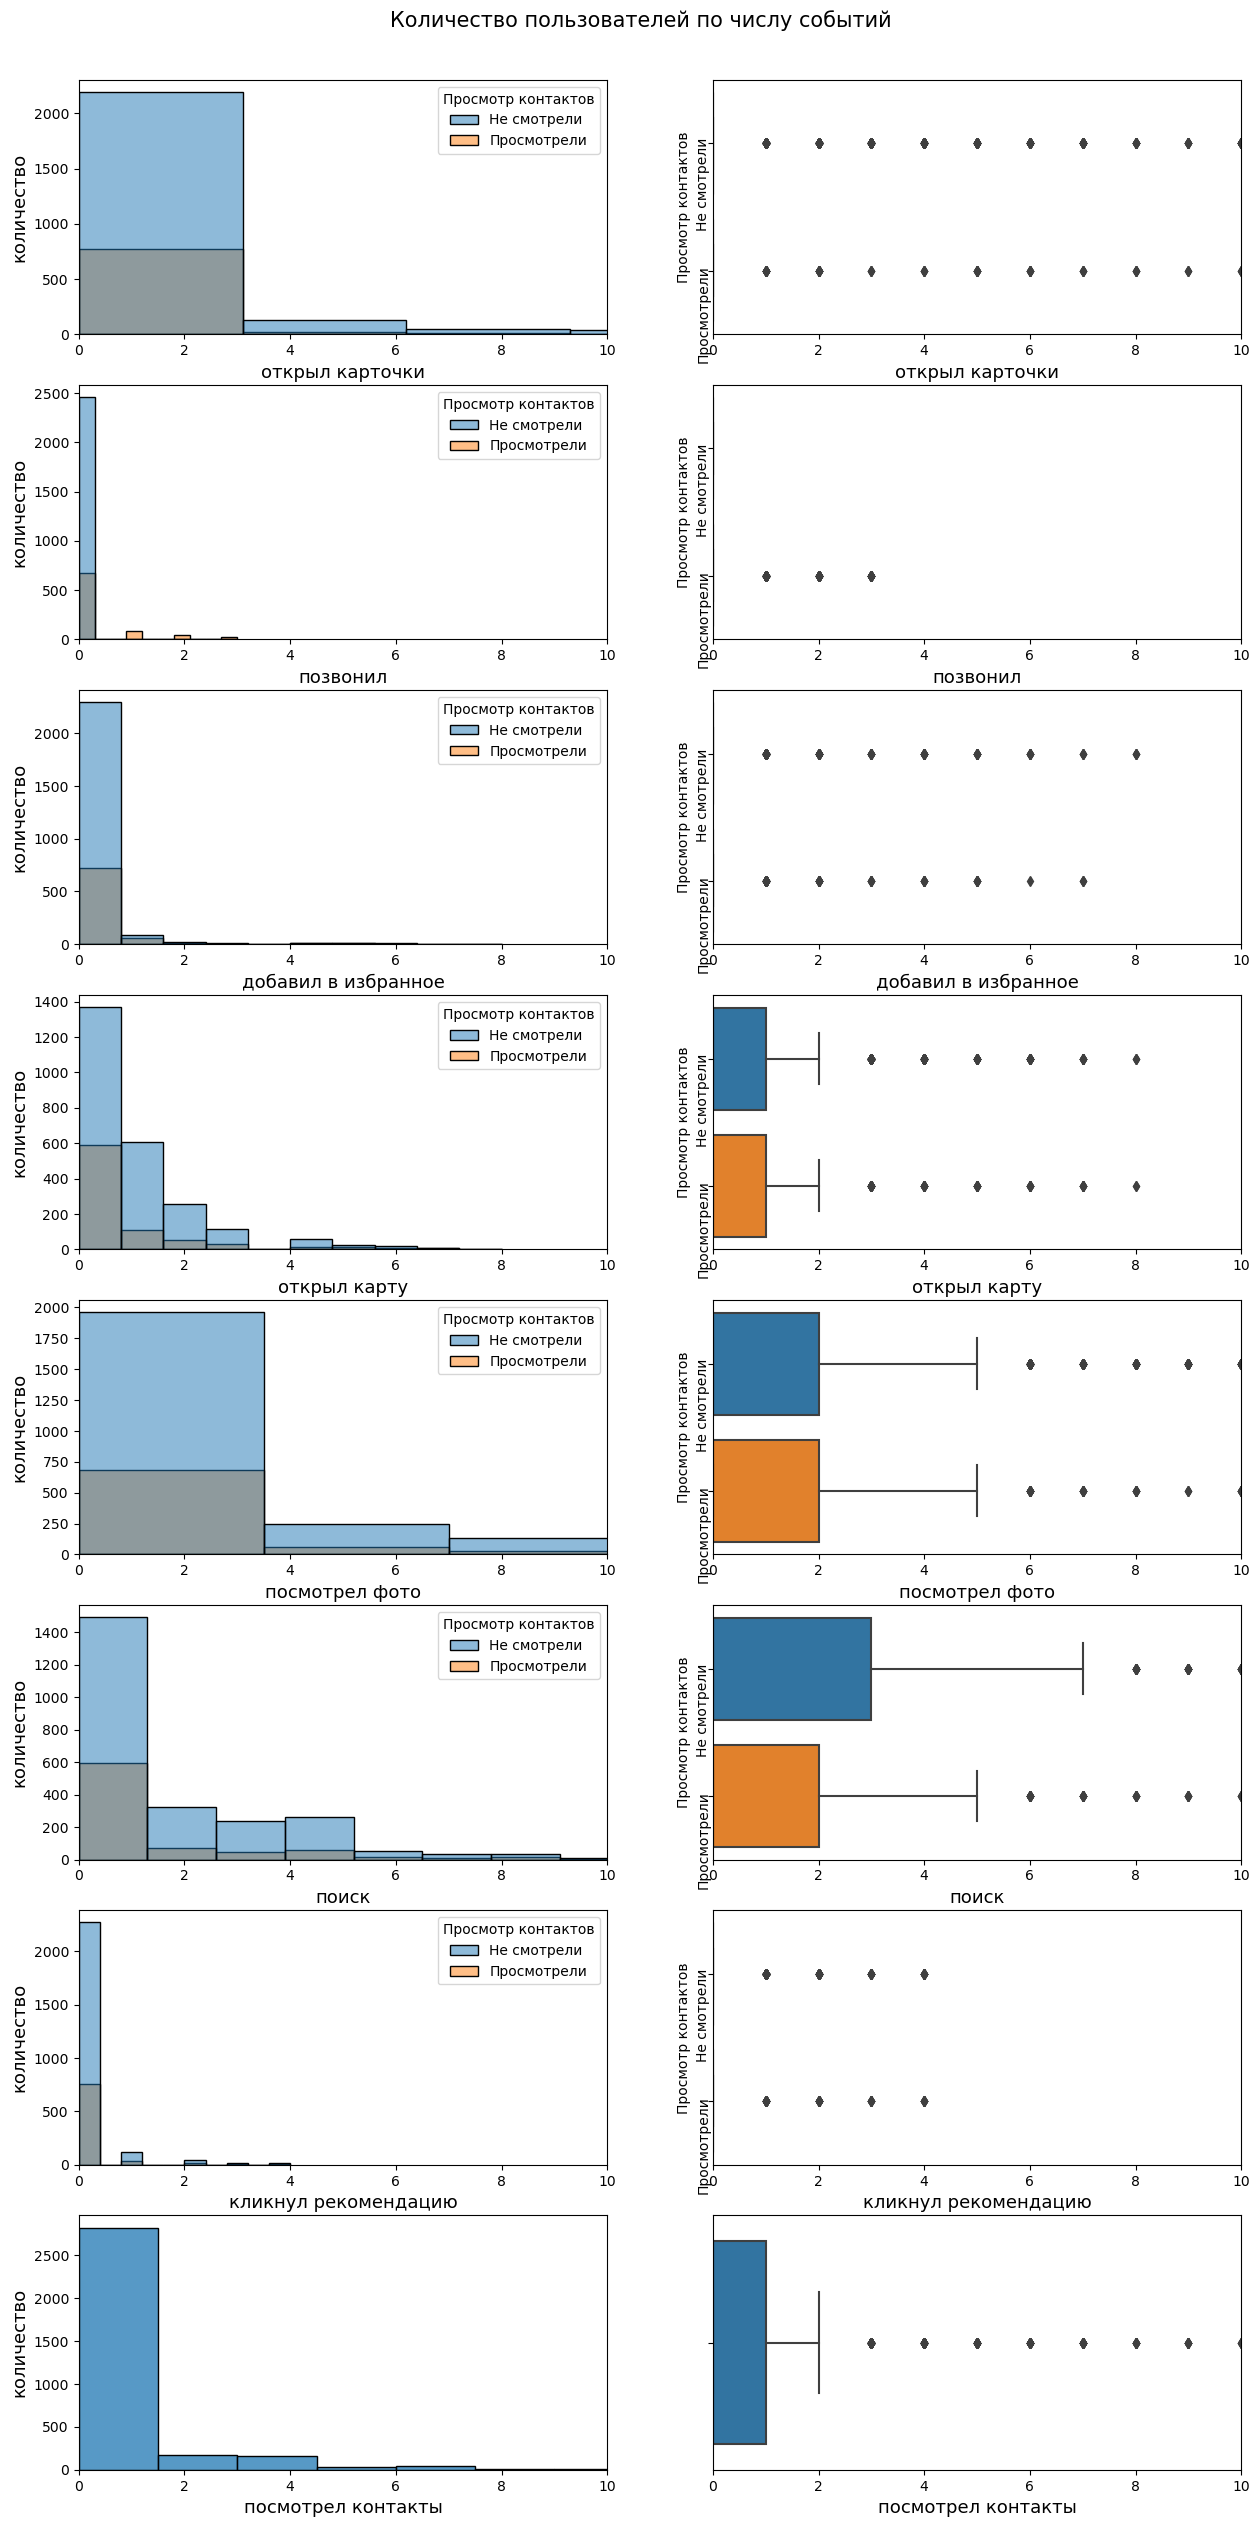

Средние значения чистых данных:


event_name
photos_show      1.97
search           1.51
advert_open      1.08
map              0.78
contacts_show    0.69
favorites_add    0.18
tips_click       0.13
contacts_call    0.08
dtype: float64

In [90]:
d_clean.loc[d_clean['target_event'] == 0, 'target_event'] = 'Не смотрели'
d_clean.loc[d_clean['target_event'] == 1, 'target_event'] = 'Просмотрели'

suspect_columns = d_clean.columns
d_for_draw = d_clean.copy()
d_for_draw['Просмотр контактов'] = d_for_draw['target_event']
plt.figure(figsize=(15, 35))
plt.suptitle('Количество пользователей по числу событий', fontsize=15, \
             color='black', backgroundcolor='white', fontstyle='normal', y=0.9)
i=1
for column in suspect_columns:
    if column=='contacts_show':
        sns.histplot(data=d_clean, bins=10, x=column,
                      ax=plt.subplot(len(suspect_columns),2,(len(suspect_columns)*2 - 3)))
        plt.xlabel(rus_dict.get(column), fontsize=13, color='black')
        plt.ylabel('количество', fontsize=13, color='black')
        plt.xticks(rotation=0, ha='center')
        plt.xlim(0, 10)
        
        sns.boxplot(data=d_clean, x=column, orient='h',
                    ax=plt.subplot(len(suspect_columns),2,(len(suspect_columns)*2 - 2)))
        plt.xlabel(rus_dict.get(column), fontsize=13, color='black')
        plt.yticks(rotation=90, ha='center')
        plt.xlim(0, 10)
    elif column=='target_event':
        continue
    else:
        sns.histplot(data=d_for_draw, x=column, bins=10, hue='Просмотр контактов', ax=plt.subplot(len(suspect_columns),2,i))
        plt.xlabel(rus_dict.get(column), fontsize=13, color='black')
        plt.ylabel('количество', fontsize=13, color='black')
        plt.xlim(0, 10)
        
        sns.boxplot(data=d_for_draw, x=column, y='Просмотр контактов', orient='h', ax=plt.subplot(len(suspect_columns),2,i+1))
        plt.xlabel(rus_dict.get(column), fontsize=13, color='black')
        plt.yticks(rotation=90, ha='center')
        plt.xlim(0, 10)
        i+=2
plt.show()
print('Средние значения чистых данных:')
d_clean.mean().sort_values(ascending=False).round(2)

В среднем пользователи совершают не больше двух одинаковых действий. Самое частое действие - просмотр фотографий - в среденем 1.97 просмотров на пользователя, второе - поиск (в среденем 1.51 запросов на пользователя), замыкает тройку лидеров - просмотр карточек (в среденем 1.08 просмотров на пользователя). Целевое действие совершается уже реже - в среднем 0.69 просмотров контактаов на пользователя.    
В разрезе целевого события, графики показывают, при одинаковых количествах действий пользователей, большая их часть не совершает целевое действие. Это связано с разной величиной выборок по целевому событию, чтобы нивелировать эту разницу, посчитаем относительные значения величин

In [91]:
d_group = d_clean.groupby('target_event').mean()
d_group

event_name,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search,tips_click
target_event,,,,,,,,
Не смотрели,1.191308,0.000000,0.000000,0.160845,0.822502,1.95329,1.585297,0.122258
Просмотрели,0.763923,0.299031,2.753027,0.251816,0.657385,2.01816,1.292978,0.157385


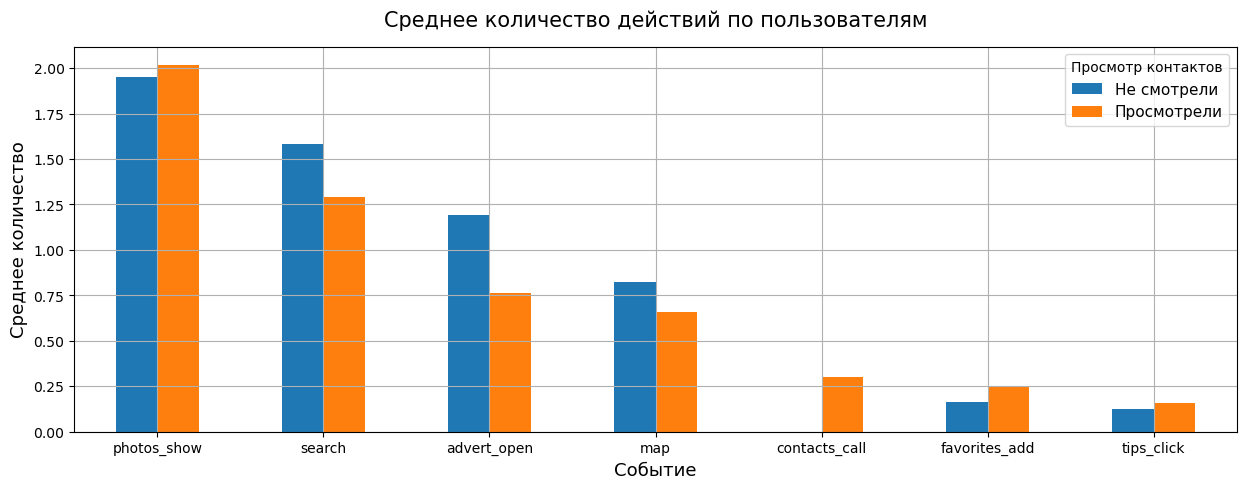

In [92]:
d_group.T.drop('contacts_show').sort_values(by='Просмотрели', ascending=False).plot(y=d_group.index, kind='bar', \
        grid=True, legend=True, figsize=(15, 5))
plt.title('Среднее количество действий по пользователям', loc ='center', pad = 15, fontsize=15, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Событие', fontsize=13, color='black')
plt.ylabel('Среднее количество', fontsize=13, color='black')
plt.xticks(rotation=0, ha='center')
plt.legend(fontsize=11, title='Просмотр контактов')
plt.show()

Относительные величины разделили события на две группы: пользователи, не совершившие целевое действие чаще используют поиск, просматривают карточки объявлений и карту; пользователи, совершившие целевое действие чаще смотрят фотографии, добавляют в избранное и кликают по рекомендациям

#### Активность пользователей по времени <a id='activity_time'></a>

Рассмотрим, как менялось количество совершения целевых действий по дням

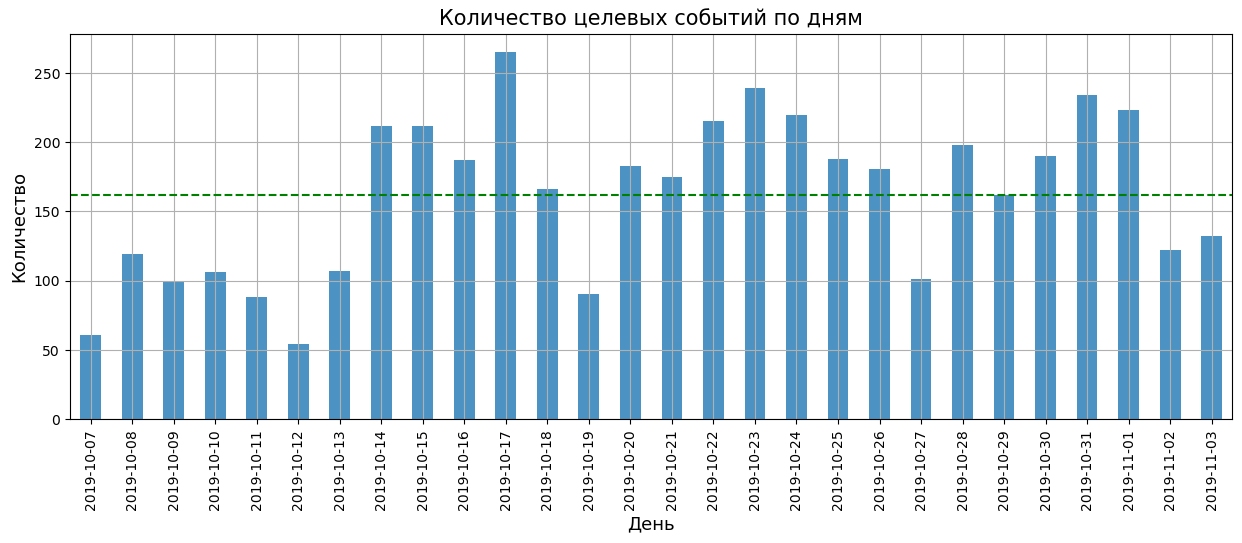

Среднее количество просмотров контактов в день - 161.75


In [93]:
data_clean['event_time'] = pd.to_datetime(data_clean['event_time']).dt.date
data_date = data_clean.query('event_name == "contacts_show"').groupby('event_time').agg({'event_name': 'count'})
mean_show = data_date.mean().values

data_date.plot(y='event_name', kind='bar', figsize=(15, 5), legend=False, alpha=0.8, grid=True)
plt.axhline(y=mean_show[0], color='green', linestyle='--')
plt.title(label='Количество целевых событий по дням', fontsize=15)
plt.xlabel('День', fontsize=13)
plt.ylabel('Количество', fontsize=13)
plt.show()
print('Среднее количество просмотров контактов в день -', mean_show[0])

Динамика совершения целевых событий довольно стабильна и не отходит далеко от среднего значения - 161.75 событий в день. На графике прослеживается влияние недельных циклов активности. В начале графика значения ниже средних, что является следствием того, что в исследовании участвуют только новые пользователи и в первую неделю мы видим только их активность, в последующие недели к ним прибавляется активность новых пользователей и количество просмотров контактов вырастает

#### Вывод: <a id='conclusion3'></a>

В таблице с событиями содержатся данные о 74197 действиях, совершенных 4293 уникальными пользователями с 2019-10-07 по 2019-11-03. Наиболее частое событие в данных, это 'tips_show', оно встречается в 40 раз чаще других событий, но, поскольку оно не зависит от действий пользователя, а нам важно учитывать именно пользовательские алгоритмы, события 'tips_show' были удалены и далее будут рассмотрены отдельно.    

По очищеным данным больше всего событий, связаных с просмотром фотографий - 10012. На втором месте в рейтинге событий - действия, связанные с поиском - 6784 события. Замыкает тройку лидеров - просмотр карточек объявления - 6164 просмотра. Хорошим знаком является то, что целевое действие - просмотр контактов, находится на четвёртом месте по количеству событий в данных - 4529 просмотров.    

В среднем пользователи совершают не больше двух одинаковых действий. Самое частое действие - просмотр фотографий - в среденем 1.97 просмотров на пользователя, второе - поиск (в среденем 1.51 запросов на пользователя), замыкает тройку лидеров - просмотр карточек (в среденем 1.08 просмотров на пользователя). Целевое действие совершается уже реже - в среднем 0.69 просмотров контактаов на пользователя.
В разрезе целевого события, при одинаковых количествах действий пользователей, большая их часть не совершает целевое действие, что связано с разной величиной выборок по целевому событию, чтобы нивелировать эту разницу, были посчитаны относительные значения величин, которые разделили события на две группы: пользователи, не совершившие целевое действие чаще используют поиск, просматривают карточки объявлений и карту; пользователи, совершившие целевое действие чаще смотрят фотографии, добавляют в избранное и кликают по рекомендациям.    

Динамика совершения целевых событий по времени довольно стабильна и не отходит далеко от среднего значения - 161.75 событий в день. Прослеживается влияние недельных циклов активности. На начальном этапе наблюдения значения ниже средних, что является следствием того, что в исследовании участвуют только новые пользователи и в первую неделю мы видим только их активность, в последующие недели к ним прибавляется активность новых пользователей и количество просмотров контактов вырастает.

Самой популярной платформой для установки приложения является Яндекс - 1934 установки, Google отстал почти в два раза - 1129 установок. Из прочих источников накопилось 1230 установок, что что вывело прочие источники на второе место в рейтинге платформ

### Продуктовые метрики оценки пользовательской активности <a id='metrics'></a>

#### Расчёт DAU <a id='dau'></a>

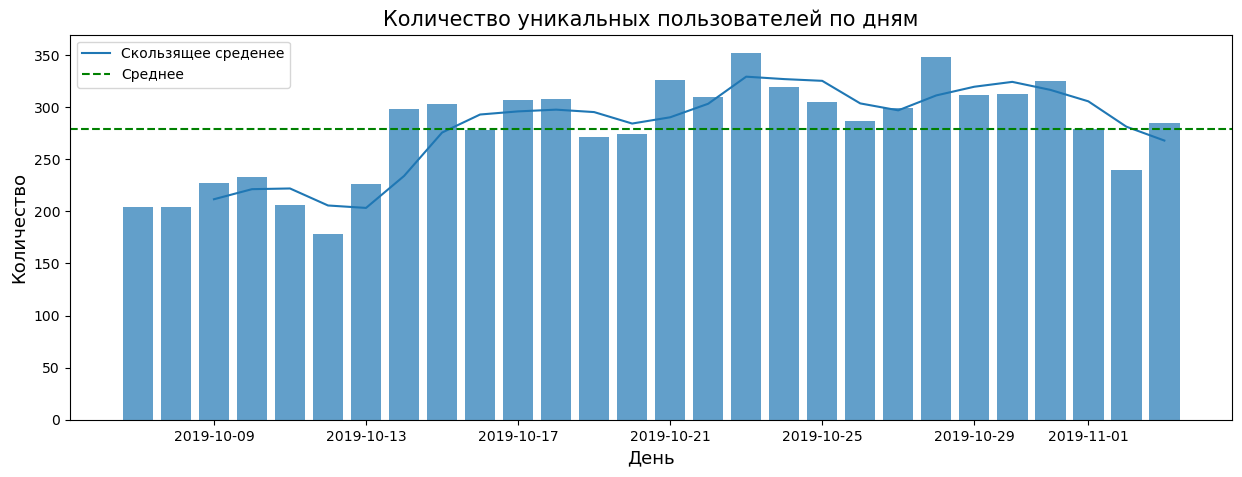

Среднее значение DAU за период наблюдений - 279.18


In [94]:
data_dau = data_m.copy()
data_dau['date'] = pd.to_datetime(data_dau['event_time']).dt.date

data_dau = (data_dau.groupby('date').agg({'user_id': 'nunique'}))
dau_total = data_dau.mean().values

plt.figure(figsize=(15, 5)) 
plt.bar(data_dau.index, data_dau['user_id'], alpha=0.7)
plt.plot( data_dau['user_id'].rolling(window=3).mean().shift(0), label='Скользящее среденее')

plt.axhline(y=dau_total, color='green', linestyle='--', label='Среднее')
plt.title(label='Количество уникальных пользователей по дням', fontsize=15)
plt.xlabel('День', fontsize=13)
plt.ylabel('Количество', fontsize=13)
plt.legend()
plt.show()
print('Среднее значение DAU за период наблюдений -', round(dau_total[0], 2))

Динамика количества аутентичных пользователей по дням довольно стабильна и близка к среднему значению за период наблюдений - 279.18 уникальных полдьзователей. На графике прослеживается влияние недельных циклов активности и пониженное значение на первой неделе, из-за использования в исследовании только данных новых юзеров, без учёта активности ранее зарегистриованных пользователей

#### Расчёт конверсии <a id='conversion'></a>

Для расчёта конверсии зададим функцию 'get_conversion'

In [95]:
def get_conversion(
    profiles,
    purchases,  # заменили sessions
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # Шаг 1. Получить пользовательские профили и данные о покупках
    # передаём их в качестве аргументов profiles и purchases

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # Шаг 2. Найти дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )
    #display(first_purchases)
    # Шаг 3. Добавить данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )
    
    # Шаг 4. Рассчитать лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    #display(result_raw)

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):

        # Шаг 5. Построить таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )

        # Шаг 6. Посчитать сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)

        # Шаг 7. Вычислить размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        # Шаг 8. Объединить таблицы размеров когорт и конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        # Шаг 9. Разделить каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)

        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

Создаём профили, таблицу с данными о целевом событии, формируем желаемые группы для сравнения их конверсии

In [96]:
# Задаём группу по признаку действий с рекомендациями
data_tips = data_m.groupby('user_id').agg({'event_name': 'unique'})
data_tips['tips'] = 0
data_tips['target'] = 0
for index in data_tips.index:
    for events in data_tips.loc[index, 'event_name']:

        if 'tips_show' in events:
            data_tips.loc[index, 'tips'] += 1
        if 'tips_click' in events:
            data_tips.loc[index, 'tips'] += 1
        if 'contacts_show' in events:
            data_tips.loc[index, 'target'] += 1
            
data_tips.loc[data_tips['tips'] == 1, 'tips'] = 'show'
data_tips.loc[data_tips['tips'] == 2, 'tips'] = 'show_click'
data_tips.reset_index(inplace=True)

# Создаём профили пользователей
profiles = data_m.pivot_table(index='user_id', values='event_time', aggfunc={'event_time' : 'min'})
profiles['event_time'] = pd.to_datetime(profiles['event_time']).dt.date
profiles = profiles.rename(columns={'event_time': 'dt'})
profiles = profiles.merge(data_s, on='user_id') # Добавляем группу по источнику трафика
profiles = profiles.merge(data_tips, on='user_id') # Добавляем группу по действиям с рекомендациями
profiles['all_users'] = 1 # Добавляем группу, включающую всех пользователей
profiles['first_ts'] = profiles['dt']
#display(profiles)

# Определяем первую транзакцию
first_ts_search = data_m.query('event_name == "contacts_show"') \
                        .pivot_table(index='user_id', values='event_time', aggfunc={'event_time' : 'min'})
first_ts_search['event_time'] = pd.to_datetime(first_ts_search['event_time']).dt.date
first_ts_search = first_ts_search.rename(columns={'event_time': 'first_ts'})
first_ts_search.reset_index(inplace=True)

# Создаём таблицу с целевыми событиями
orders = data_m.query('event_name == "contacts_show"').loc[:,['event_time', 'user_id', 'event_name']]
orders['event_time'] = pd.to_datetime(orders['event_time']).dt.date
orders = orders.rename(columns={'event_time': 'event_dt'})
orders = orders.groupby(['user_id', 'event_dt']).agg({'event_name' : 'count'})
orders.reset_index(level=1, inplace=True)
orders = orders.sort_values(by='event_dt')

Как показала метрика DAU, пользователям свойственны недельные циклы активности, чтобы сгладить их влияние на расчёт конверсии, установим значение горизонта анализа в 10 дней, это позволит более точно расчитать конверсию, чем при горизонте анализа в неделю, а потери данных составят всего три дня. При довольно стабильной динамике активности пользователей, оптимально будет отказаться от дополнительных когорт, в пользу более точного расчёта метрики.    

На первом этапе посчитаем общую конверсию по всем пользователям.

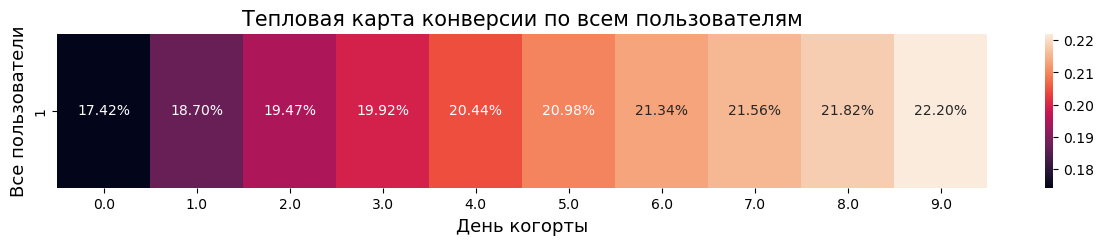

In [97]:
# получаем сырые данные, таблицу конверсии и таблицу динамики конверсии
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019,11,3).date(), 10, dimensions=['all_users']
)

# строим хитмэп по таблице конверсии
plt.figure(figsize=(15, 2))
sns.heatmap(conversion.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title(label='Тепловая карта конверсии по всем пользователям', fontsize=15)
plt.xlabel('День когорты', fontsize=13)
plt.ylabel('Все пользователи', fontsize=13)
plt.show() 

Пользователи показывают хороший уровень конверсии 22.2% на десятый день. Каждый пятый пользователь совершает целевое действие. За десять дней жизни когорты, показатель конверсии вырос на 5 процентных пунктов.

Далее посмотрим, как влияют на конверсию действия с рекомендациями

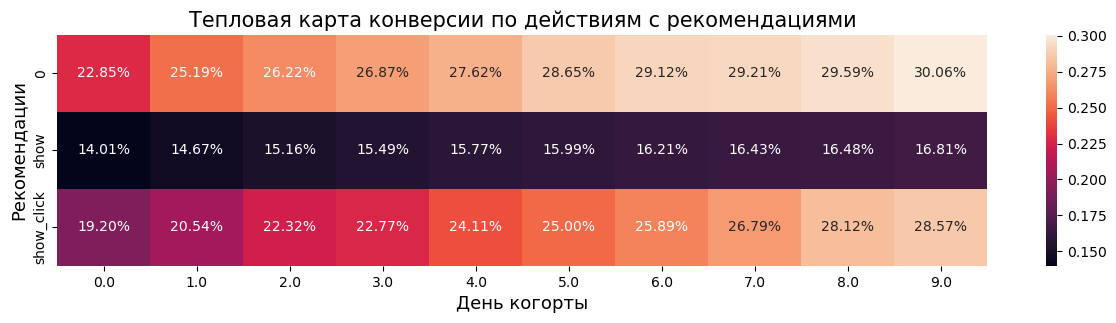

In [98]:
# получаем сырые данные, таблицу конверсии и таблицу динамики конверсии
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019,11,3).date(), 10, dimensions=['tips']
)

# строим хитмэп по таблице конверсии
plt.figure(figsize=(15, 3))
sns.heatmap(conversion.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title(label='Тепловая карта конверсии по действиям с рекомендациями', fontsize=15)
plt.xlabel('День когорты', fontsize=13)
plt.ylabel('Рекомендации', fontsize=13)
plt.show() 

Расчёт показал, что конверсия лучше у пользователей, посмотревших рекомендации и кликнувших на них, чем у пользователей, которые только посмотрели рекомендации. Разница в конверсии на десятый день составила более 10 процентных пунктов. Также конверсия посмотревших и кликнувших на рекомендации выше средней конверсии по всем пользователям на 6 процентных пунктов.

На основе расчёта конверсии сформируем гипотезу: у группы, совершающей действия tips_show и tips_click, конверсия в просмотры контактов отличается от группы совершающей только tips_show. Далее в исследовании сделаем проверку этой гипотезы.

Расчитаем как влияет на конверсию источник установки приложения

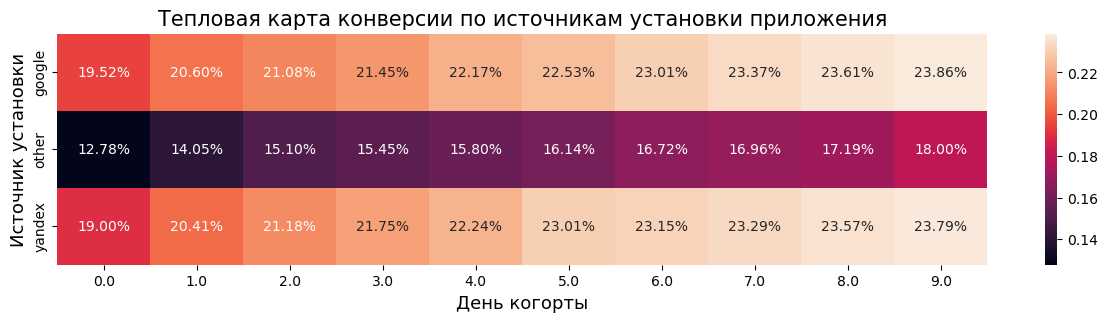

In [99]:
# получаем сырые данные, таблицу конверсии и таблицу динамики конверсии
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019,11,3).date(), 10, dimensions=['source']
)

# строим хитмэп по таблице конверсии
plt.figure(figsize=(15, 3))
sns.heatmap(conversion.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title(label='Тепловая карта конверсии по источникам установки приложения', fontsize=15)
plt.xlabel('День когорты', fontsize=13)
plt.ylabel('Источник установки', fontsize=13)
plt.show() 

Конверсия по источникам установки приложения у Yandex и Google показала схожие значения: 23.79% и 23.86% соответственно. Это выше значения конверсии по всем пользователям примерно на полтора процентных пункта. Конверсия пользователей, пришедших из других источников сильно отстаёт и не превышает 18%.    

Поскольку значения конверсии для Google и Yandex довольно близки, для определения дальнейшей стратегии работы с источниками трафика, нам придётся проверить их различие статистически, для чего выдвенем и проверим гипотезу о том, что конверсия в просмотры контактов различается у этих двух групп 

#### Расчёт длительности сессии <a id='session'></a>

Рассмотрим характерные длительности сессии и как они влияют на целевое событие.    
Сначала определим оптимальный интервал между сессиями: посмотрим в каких пределах находятся интервалы между событиями для большей части пользователей

In [100]:
# Формируем и сортируем датасет для деления на сессии
data_sessions = data_m.copy()
data_sessions = data_sessions.rename(columns={'event_time': 'timestamp'})
data_sessions = data_sessions.sort_values(['user_id', 'timestamp'])
for quant in [0.9, 0.91, 0.92, 0.93, 0.94, 0.95]:
    print('Для', str(quant * 100) + '% пользователей интервал между событиями меньше',
          data_sessions.groupby('user_id')['timestamp'].diff().quantile(q=quant))

Для 90.0% пользователей интервал между событиями меньше 0 days 00:17:00.807463700
Для 91.0% пользователей интервал между событиями меньше 0 days 00:25:44.431370130
Для 92.0% пользователей интервал между событиями меньше 0 days 00:45:25.305054720
Для 93.0% пользователей интервал между событиями меньше 0 days 01:29:59.289758190
Для 94.0% пользователей интервал между событиями меньше 0 days 03:31:32.660409639
Для 95.0% пользователей интервал между событиями меньше 0 days 10:24:36.433909349


Оптимальным будет взять среднее значение из полученных - 45 минут, поскольку интервал в 25 минут может проходить в рамках одной сессии, если пользователь загружен паралельными задачами, а следующий интервал в полтора часа является мало реалистичным перерывом в рамках одной сессии мобильного приложения

In [101]:
# Идентифицируем сесси по пользователям. Интервал в 45 минут без событий закрывает сессию  
g = (data_sessions.groupby('user_id')['timestamp'].diff() > pd.Timedelta('45Min')).cumsum()

# Делаем id для сессий
data_sessions['session_id'] = data_sessions.groupby(['user_id', g], sort=False).ngroup() + 1

# Формируем столбец с индикатором успешности сессии
data_sessions['success'] = [x == 'contacts_show' for x in data_sessions['event_name']]

# Формируем сводную таблицу по сессиям
data_sessions_duration = data_sessions.pivot_table(index = 'session_id', values=['timestamp', 'success'], 
                                          aggfunc=({'success' : lambda x: max(x),
                                                   'timestamp' : [ lambda x: (max(x) - min(x)).seconds, 'min', 'max'] 
                                                   }))
data_sessions_duration.reset_index(inplace=True)
data_sessions_duration.columns = ['session_id', 'target_event', 'duration', 'session_end', 'session_start']
data_sessions_duration = data_sessions_duration.query('duration > 0')

Сессии всех пользователей 
 count     7958.000000
mean      1137.302966
std       1540.836807
min          1.000000
25%        206.000000
50%        611.000000
75%       1486.750000
max      22055.000000
Name: duration, dtype: float64

Сессии пользователей, совершивших целевое действие 
 count     1535.000000
mean      1569.861889
std       1923.813311
min          1.000000
25%        261.000000
50%        870.000000
75%       2196.000000
max      16637.000000
Name: duration, dtype: float64

Сессии пользователей, не совершивших целевое действие 
 count     6423.000000
mean      1033.927915
std       1414.987627
min          1.000000
25%        198.000000
50%        564.000000
75%       1341.000000
max      22055.000000
Name: duration, dtype: float64


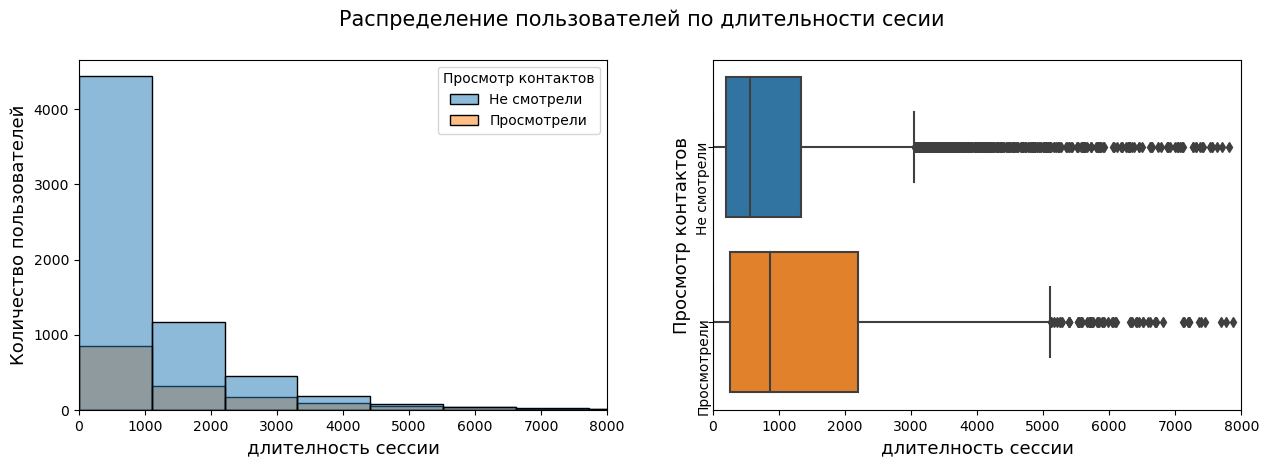

In [102]:
plt.figure(figsize=(15, 10))
plt.suptitle('Распределение пользователей по длительности сесии', fontsize=15, \
             color='black', backgroundcolor='white', fontstyle='normal', y=0.93)

duration_for_draw = data_sessions_duration.copy()
duration_for_draw['Просмотр контактов'] = duration_for_draw['target_event']
duration_for_draw.loc[duration_for_draw['Просмотр контактов'] == True, 'Просмотр контактов'] = 'Просмотрели'
duration_for_draw.loc[duration_for_draw['Просмотр контактов'] == False, 'Просмотр контактов'] = 'Не смотрели'

sns.histplot(data=duration_for_draw, x='duration', bins=20, hue='Просмотр контактов', ax=plt.subplot(2,2,1))
plt.xlabel(rus_dict.get('duration'), fontsize=13)
plt.ylabel('Количество пользователей', fontsize=13)
plt.xlim(0, 8000)

sns.boxplot(data=duration_for_draw, x='duration', y='Просмотр контактов', orient='h', ax=plt.subplot(2,2,2))
plt.yticks(rotation=90, ha='center')
plt.xlim(0, 8000)
plt.xlabel(rus_dict.get('duration'), fontsize=13)
plt.ylabel('Просмотр контактов', fontsize=13)

print('Сессии всех пользователей \n',
      data_sessions_duration['duration'].describe())
print('\nСессии пользователей, совершивших целевое действие \n', 
      data_sessions_duration.query('target_event == True')['duration'].describe())
print('\nСессии пользователей, не совершивших целевое действие \n', 
      data_sessions_duration.query('target_event == False')['duration'].describe())
plt.show()

Медианное значение длительности сессии для пользователей составляет 611 секунд, но в данных присутствует значительное число сессий с повышенной длительностью, которые утягивают среднее вверх до длительности 1137 секунд. Для пользователей, не совершивших целевое действие, медианное и среднее значение длительности сессии чуть меньше общего и составляет 564 и 1033 секунд соответственно, большая часть значений не превышает полутора тысяч секунд, а сессии более 3000 секунд можно считать аномально большими. Для пользователей, которые совершили целевое действие, напротив характерна медианная и средняя длительность сесси выше общих: медианное значение - 870 секунд, среднее - 1569 секунд, разброс значений также смещён в большую сторону: 75% сессий имеют длительность до 2196 секунд, а аномальные большими значениями длительности можно считать сессии, продолжающиеся более 5000 секунд

#### Вывод: <a id='conclusion4'></a>

Динамика количества аутентичных пользователей по дням довольно стабильна и близка к среднему значению за период наблюдений - 279.18 уникальных пользователей. Прослеживается влияние недельных циклов активности и пониженное значение на первой неделе, из-за использования в исследовании только данных новых юзеров, без учёта активности ранее зарегистриованных пользователей

В целом пользователи показывают хороший уровень конверсии 22.2% на десятый день. Каждый пятый пользователь совершает целевое действие. За десять дней жизни когорты, показатель конверсии вырос на 5 процентных пунктов.

Расчёт показал, что конверсия лучше у пользователей, посмотревших рекомендации и кликнувших на них, чем у пользователей, которые только посмотрели рекомендации. Разница в конверсии на десятый день составила более 10 процентных пунктов. Также конверсия посмотревших и кликнувших на рекомендации выше средней конверсии по всем пользователям на 6 процентных пунктов.

Конверсия по источникам установки приложения у Yandex и Google показала схожие значения: 23.79% и 23.86% соответственно. Это выше значения конверсии по всем пользователям примерно на полтора процентных пункта. Конверсия пользователей, пришедших из других источников сильно отстаёт и не превышает 18%.

Медианное значение длительности сессии для пользователей составляет 611 секунд, но в данных присутствует значительное число сессий с повышенной длительностью, которые утягивают среднее вверх до длительности 1137 секунд. Для пользователей, не совершивших целевое действие, медианное и среднее значение длительности сессии чуть меньше общего и составляет 564 и 1033 секунд соответственно, большая часть значений не превышает полутора тысяч секунд, а сессии более 3000 секунд можно считать аномально большими. Для пользователей, которые совершили целевое действие, напротив характерна медианная и средняя длительность сесси выше общих: медианное значение - 870 секунд, среднее - 1569 секунд, разброс значений также смещён в большую сторону: 75% сессий имеют длительность до 2196 секунд, а аномальные большими значениями длительности можно считать сессии, продолжающиеся более 5000 секунд

### Анализ сценариев активности пользователей <a id='pattern'></a>

#### Диаграмма Сэнкея <a id='sankey'></a>

На первом этапе подготовим чистые сессии для диаграммы Сэнкея:
- оставим в сессиях только уникальные действия пользователей
- оставим только успешные сессии
- событие 'tips_show' не зависит от действия пользователя и из-за этого может вклиниваться в последовательности его действий и вносить искажения в искомые паттерны. Чтобы избежать этого, удалим события 'tips_show' из данных для диаграммы Сэнкея. Вместе с тем, конверсия 'tips_show' в 'tips_click' - является важным фактором взаимодействия с платформой, поэтому, перед удалением событий, отдельно сохраним данные по ним и далее используем для построения воронки

In [103]:
# Оставляем в сессии только уникальные действия, без повторов
data_sessions_clean = data_sessions.drop_duplicates(subset=['session_id', 'event_name'], keep='first')

# Добавляем датафрейм с индикатором успешности сессии
data_sessions_clean = data_sessions_clean.merge(data_sessions_duration, on='session_id', how='left')

# Оставляем только успешные сессии
data_sessions_clean = data_sessions_clean.query('target_event == True')

# Делаем целевое событие последним: удаляем последние события, не явяющиеся целевым.
# Выполняем цикл до тех пор, пока в списке последних событий (u_list) будет одно уникальное значение
check = 100
stoper = 1
while check != 1:
  
    group = data_sessions_clean.copy()
    group.reset_index(inplace=True)
    group = group.groupby('session_id').agg({'event_name' : 'last', 'index' : 'max'} )
    data_sessions_clean.drop(group.loc[group['event_name'] != 'contacts_show', 'index'].tolist(), inplace=True)
    u_list = data_sessions_clean.groupby('session_id').agg({'event_name' : 'last'})['event_name'].unique()

    stoper += 1
    if stoper == 50:
        check = 1
    else:
        check = len(u_list)
        
# Запишем количество событий сессийй, с последовательностью tips_show, tips_click', 'contacts_show'
tips_show_count = 0 # данные для воронки
tips_click_count = 0 # данные для воронки
tips_contact_count = 0 # данные для воронки
click = 0
s_index = 0
contacts_to_del = []

for index in data_sessions_clean.index:
    if s_index == 0:
        previos_index = index
        s_index += 1
        continue
    
    if data_sessions_clean.loc[previos_index, 'event_name'] == 'tips_show':
        tips_show_count += 1
        if data_sessions_clean.loc[index , 'event_name'] != 'tips_click' and \
            data_sessions_clean.loc[index, 'session_id'] == data_sessions_clean.loc[previos_index , 'session_id']:
            data_sessions_clean.drop(previos_index, inplace=True)
            click = 0
        elif  data_sessions_clean.loc[index , 'event_name'] == 'tips_click' and \
            data_sessions_clean.loc[index, 'session_id'] == data_sessions_clean.loc[previos_index , 'session_id']:
            tips_click_count += 1
            click = 1
            
    elif (data_sessions_clean.loc[previos_index , 'event_name'] == 'tips_click' and \
          data_sessions_clean.loc[index , 'event_name'] == 'contacts_show' and \
          data_sessions_clean.loc[index, 'session_id'] == data_sessions_clean.loc[previos_index , 'session_id']) and \
          click == 1:
        tips_contact_count += 1
        click = 0
        contacts_to_del.append(index)

    previos_index = index

# удалим tips_show, tips_click, удаляем пропуски и сортируем итоговый чистый датафрейм для Сэнкея 
data_indexes = data_sessions_clean.copy()
data_indexes.reset_index(inplace=True)
kill_list = data_indexes.loc[data_indexes['event_name'] == 'tips_click', 'index'].tolist()  
kill_tips = data_indexes.loc[data_indexes['event_name'] == 'tips_show', 'index'].tolist()

data_sessions_clean.drop(kill_list, inplace=True)
data_sessions_clean.drop(kill_tips, inplace=True)
data_sessions_clean.drop(contacts_to_del, inplace=True)     

# Убираем сессии, начинающиеся с целевого события
group_2 = data_sessions_clean.copy()
group_2.reset_index(inplace=True)
group_2 = group_2.groupby('session_id').agg({'event_name' : 'first', 'index' : 'min'} )
data_sessions_clean.drop(group_2.loc[group_2['event_name'] == 'contacts_show', 'index'].tolist(), inplace=True)
data_sessions_clean = data_sessions_clean.dropna()
data_sessions_clean = data_sessions_clean.copy().reset_index(drop=True)
data_sessions_clean = data_sessions_clean.sort_values(by=['session_id', 'timestamp']).copy()
data_sessions_clean.head()

,timestamp,event_name,user_id,session_id,success,target_event,duration,session_end,session_start
0,2019-10-20 18:49:24.115634,search,00157779-810c-4498-9e05-a1e9e3cedf93,6,False,True,4572.0,2019-10-20 20:05:36.234073,2019-10-20 18:49:24.115634
1,2019-10-20 18:59:22.541082,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,6,False,True,4572.0,2019-10-20 20:05:36.234073,2019-10-20 18:49:24.115634
2,2019-10-20 19:03:02.030004,favorites_add,00157779-810c-4498-9e05-a1e9e3cedf93,6,False,True,4572.0,2019-10-20 20:05:36.234073,2019-10-20 18:49:24.115634
3,2019-10-20 19:17:18.659799,contacts_show,00157779-810c-4498-9e05-a1e9e3cedf93,6,True,True,4572.0,2019-10-20 20:05:36.234073,2019-10-20 18:49:24.115634
4,2019-10-29 21:18:24.850073,search,00157779-810c-4498-9e05-a1e9e3cedf93,8,False,True,3120.0,2019-10-29 22:10:25.712840,2019-10-29 21:18:24.850073


Получили таблицу с сессиями, содержащими только уникальные события, заканчивающимися целевым действием, без 'tips_show' и 'tips_click', сгруппированную по сессиям и временным меткам.

На основе этих данных сначала создадим таблицу линейных потоков, чтобы посмотреть основыные длительности и количество последовательностей по типу

In [104]:
def flow_maker(df=data_sessions_clean):
    
    ''' Создаём потоки действий пользователей в виде списков.
    '''
    
    # Создаём словарь, где ключ - session_id, значение - список последовательных событий сессии
    flow_list = []
    flow_dict = {}
    old_session = 6
    for ind in df.index:
        if df.loc[ind, 'session_id'] != old_session:
            flow_dict[old_session] = flow_list
            flow_list = []
            flow_list.append(df.loc[ind, 'event_name'])
        else:
            flow_list.append(str(df.loc[ind, 'event_name']))

        old_session = int(df.loc[ind, 'session_id'])
    return flow_dict

dictionary = flow_maker()

# Считаем долю каждого потока среди общего количества паттернов
counter = 0
dictionary_lenght = {}
for element in dictionary:
    counter += len(dictionary[element])
    dictionary_lenght[element] = round(int(len(dictionary[element])))

# Группируем по сессиям датафрейм и добавляем потоки и их длинну
flow_data = data_sessions_clean.groupby('session_id').agg({'duration' : 'max'})
flow_data['flow'] = pd.Series(dictionary)
flow_data['flow_lenght'] = pd.Series(dictionary_lenght)
flow_data = flow_data.dropna()
flow_data.reset_index(inplace=True)

flow_data_grouped = flow_data.copy()
flow_data_grouped['flow'] = [', '.join(x) for x in flow_data_grouped['flow'].values]
flow_data_grouped = flow_data_grouped.groupby('flow').agg({'duration' : 'count', 'flow_lenght' : 'max'})
flow_data_grouped['part'] = round((flow_data_grouped['duration'] / flow_data_grouped['duration'].sum()) * 100, 2)
flow_data_grouped.sort_values(by='duration', ascending=False).head(10)

,duration,flow_lenght,part
flow,,,
"search, contacts_show",191,2.0,26.34
"map, contacts_show",166,2.0,22.90
"photos_show, contacts_show",131,2.0,18.07
"search, photos_show, contacts_show",66,3.0,9.10
"advert_open, contacts_show",28,2.0,3.86
"map, advert_open, contacts_show",26,3.0,3.59
"favorites_add, contacts_show",16,2.0,2.21
"search, map, contacts_show",14,3.0,1.93
"photos_show, search, contacts_show",12,3.0,1.66


Самые популярные сценарии не превышают трёх этапов, поэтому диаграмму Сэнкея ограничим тремя шагами. Ширина самых популярных потоков не меньше десяти повторений, поэтому значения отсечём потоки с шириной меньше 10, чтобы не усложнять схему.

Далее формируем шаги для Сэнкея

In [105]:
def add_features(df):
    
    '''Функция генерации новых столбцов для исходной таблицы

    Args:
        df (pd.DataFrame): исходная таблица.
    Returns:
        pd.DataFrame: таблица с новыми признаками.
    '''
    
    # сортируем по id и времени
    sorted_df = df.copy()
    # добавляем шаги событий
    sorted_df['step'] = sorted_df.groupby('session_id').cumcount() + 1
    
    # добавляем узлы-источники и целевые узлы
    # узлы-источники - это сами события
    sorted_df['source'] = sorted_df['event_name']
    # добавляем целевые узлы
    sorted_df['target'] = sorted_df.groupby('session_id')['source'].shift(-1)
    
    # возврат таблицы без имени событий
    return sorted_df.drop(['event_name'], axis=1)
  
# преобразуем таблицу
table = add_features(data_sessions_clean)

Ограничиваем диаграмму Сэнкея тремя шагами

In [106]:
# удалим все пары source-target, шаг которых больше трёх
# и сохраним полученную таблицу в отдельную переменную
df_comp = table[table['step'] < 4].copy().reset_index(drop=True)

Создаём словарь с индексами источника и цели для шагов диаграммы

In [107]:
def get_source_index(df):
    
    '''Функция генерации индексов source

    Args:
        df (pd.DataFrame): исходная таблица с признаками step, source, target.
    Returns:
        dict: словарь с индексами, именами и соответсвиями индексов именам source.
    '''
    
    res_dict = {}
    
    count = 0
    # получаем индексы источников
    for no, step in enumerate(df['step'].unique().tolist()):
        # получаем уникальные наименования для шага
        res_dict[no+1] = {}
        res_dict[no+1]['sources'] = df[df['step'] == step]['source'].unique().tolist()
        res_dict[no+1]['sources_index'] = []
        for i in range(len(res_dict[no+1]['sources'])):
            res_dict[no+1]['sources_index'].append(count)
            count += 1
            
    # соединим списки
    for key in res_dict:
        res_dict[key]['sources_dict'] = {}
        res_dict[key]['sources_dict_by_step'] = {}
        for name, no in zip(res_dict[key]['sources'], res_dict[key]['sources_index']):
            res_dict[key]['sources_dict'][name] = no
            res_dict[key]['sources_dict_by_step'][name + '_' + str(key)] = no
    return res_dict
  
# создаем словарь
source_indexes = get_source_index(df_comp)

Задаём случайные цвета для диаграммы

In [108]:
def colors_for_sources():
    
    '''Генерация случайных цветов rgba

    Returns:
        dict: словарь с цветами, соответствующими каждому индексу
    '''
    
    # словарь, в который сложим цвета в соответствии с индексом
    colors_dict = {}
 
    for label in df_comp['source'].unique():
        r, g, b = np.random.randint(255, size=3)            
        colors_dict[label] = f'rgba({r}, {g}, {b}, 1)'
                 
    return colors_dict
  
# Генерация цветов для Сэкея
colors_dict = colors_for_sources()

Считаем по индексам источников и целей ширину потоков и проценты переходов. Берём только потоки с шириной больше 10 (самые популярные, как мы выяснили ранее) и добавляем сформированные данные по цвету

In [109]:
def percent_users(sources, targets, values):
    
    '''
    Расчет уникальных id в процентах (для вывода в hover text каждого узла)
    
    Args:
        sources (list): список с индексами source.
        targets (list): список с индексами target.
        values (list): список с "объемами" потоков.
        
    Returns:
        list: список с "объемами" потоков в процентах
    '''
    
    # объединим источники и метки и найдем пары
    zip_lists = list(zip(sources, targets, values))
    
    new_list = []
    
    # подготовим список словарь с общим объемом трафика в узлах
    unique_dict = {}
    
    # проходим по каждому узлу
    for source, target, value in zip_lists:
        if source not in unique_dict:
            # находим все источники и считаем общий трафик
            unique_dict[source] = 0
            for sr, tg, vl in zip_lists:
                if sr == source:
                    unique_dict[source] += vl
                    
    # считаем проценты
    for source, target, value in zip_lists:
        new_list.append(round(100 * value / unique_dict[source], 1))
    
    return new_list

def lists_for_plot(source_indexes=source_indexes, colors=colors_dict, frac=10):
    
    '''
    Создаем необходимые для отрисовки диаграммы переменные списков и возвращаем
    их в виде словаря
    
    Args:
        source_indexes (dict): словарь с именами и индексами source.
        colors (dict): словарь с цветами source.
        frac (int): ограничение на минимальный "объем" между узлами.
        
    Returns:
        dict: словарь со списками, необходимыми для диаграммы.
    '''
    
    sources = []
    targets = []
    values = []
    labels = []
    link_color = []
    link_text = []

    # проходим по каждому шагу
    for step in tqdm(sorted(df_comp['step'].unique()), desc='Шаг'):
        if step + 1 not in source_indexes:
            continue

        # получаем индекс источника
        temp_dict_source = source_indexes[step]['sources_dict']

        # получаем индексы цели
        temp_dict_target = source_indexes[step+1]['sources_dict']

        # проходим по каждой возможной паре, считаем количество таких пар
        for source, index_source in tqdm(temp_dict_source.items()):
            for target, index_target in temp_dict_target.items():
                # делаем срез данных и считаем количество id            
                temp_df = df_comp[(df_comp['step'] == step)&(df_comp['source'] == source)&(df_comp['target'] == target)]
                value = len(temp_df)
                # проверяем минимальный объем потока и добавляем нужные данные
                if value > frac:
                    sources.append(index_source)
                    targets.append(index_target)
                    values.append(value)
                    # делаем поток прозрачным для лучшего отображения
                    link_color.append(colors[source].replace(', 1)', ', 0.2)'))
                    
    labels = []
    colors_labels = []
    for key in source_indexes:
        for name in source_indexes[key]['sources']:
            labels.append(name)
            colors_labels.append(colors[name])
            
    # посчитаем проценты всех потоков
    perc_values = percent_users(sources, targets, values)
    
    # добавим значения процентов для howertext
    link_text = []
    for perc in perc_values:
        link_text.append(f'{perc}%')
    
    # возвратим словарь с вложенными списками
    return {'sources': sources, 
            'targets': targets, 
            'values': values, 
            'labels': labels, 
            'colors_labels': colors_labels, 
            'link_color': link_color, 
            'link_text': link_text}
  

# создаем словарь
data_for_plot = lists_for_plot()

Шаг: 100%|███████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.30it/s]


Рисуем диаграмму Сэнкея

In [110]:
def plot_senkey_diagram(data_dict=data_for_plot):    
    
    '''
    Функция для генерации объекта диаграммы Сенкей 
    
    Args:
        data_dict (dict): словарь со списками данных для построения.
        
    Returns:
        plotly.graph_objs._figure.Figure: объект изображения.
    '''
    
    fig = go.Figure(data=[go.Sankey(
        domain = dict(
          x =  [0,1],
          y =  [0,1]
        ),
        orientation = 'h',
        valueformat = '.0f',
        node = dict(
          pad = 50,
          thickness = 15,
          line = dict(color = 'black', width = 0.1),
          label = data_dict['labels'],
          color = data_dict['colors_labels']
        ),
        link = dict(
          source = data_dict['sources'],
          target = data_dict['targets'],
          value = data_dict['values'],
          label = data_dict['link_text'],
          color = data_dict['link_color']
      ))])
    fig.update_layout(title_text='Диаграмма Сэнкея', font_size=10, width=900, height=600)
    
    # возвращаем объект диаграммы
    return fig
  
# сохраняем диаграмму в переменную
senkey_diagram = plot_senkey_diagram()
senkey_diagram.show()

Самыми популярными первыми шагами являются поиск, просмотр карты и просмотр фотографий. Следующим после этих действий чаще всего является просмотр контактов. Часто встречается и последовательность из трёх шагов: поиск, просмотр фотографий, просмотр контактов. Доли остальных последовательностей не превышают 5%.

#### Воронки активности пользователей <a id='funnel'></a>

На основе полученных расчётов сформируем воронки наиболее распространённых паттернов поведения пользователей. Для этого сначала зададим функцию расчёта количества значений каждого шага и функцию построения воронки

In [111]:
def create_funnel_df(df, steps, from_date=None, to_date=None, step_interval=0):
    """
    Function used to create a dataframe that can be passed to functions for generating funnel plots.
    """
    # filter df for only events in the steps list
    df = df[['distinct_id', 'name', 'time']]
    df = df[df['name'].isin(steps)]

    values = []
    # for the rest steps, create a df and filter only for that step
    for i, step in enumerate(steps):
        if i == 0:
            dfs = {}

            dfs[step] = df[df['name'] == step] \
                .sort_values(['distinct_id', 'time'], ascending=True) \
                .drop_duplicates(subset=['distinct_id', 'name'], keep='first')

            # filter df of 1st step according to dates
            if from_date:
                dfs[step] = dfs[step][(dfs[step]['time'] >= from_date)]

            if to_date:
                dfs[step] = dfs[step][(dfs[step]['time'] <= to_date)]

        else:
            dfs[step] = df[df['name'] == step]
            
            # outer join with previous step
            merged = pd.merge(dfs[steps[i - 1]], dfs[step], on='distinct_id', how='outer')
            
            # keep only rows for which the distinct_ids appear in the previous step
            valid_ids = dfs[steps[i - 1]]['distinct_id'].unique()
            merged = merged[merged['distinct_id'].isin(valid_ids)]
            

            # keep only events that happened after previous step and sort by time
            merged = merged[merged['time_y'] >=
                            (merged['time_x'] + step_interval)].sort_values('time_y', ascending=True)
            

            # take the minimum time of the valid ones for each user
            merged = merged.drop_duplicates(subset=['distinct_id', 'name_x', 'name_y'], keep='first')
            

            # keep only the necessary columns and rename them to match the original structure
            merged = merged[['distinct_id', 'name_y', 'time_y']].rename({'name_y': 'name',
                                                                         'time_y': 'time'}, axis=1)

            # include the df in the df dictionary so that it can be joined to the next step's df
            dfs[step] = merged
             # append number of users to the "values" list
        values.append(len(dfs[step]))
        
    # create dataframe
    funnel_df = pd.DataFrame({'step': steps, 'val': values})
    # calculate percentage conversion for each step
    funnel_df['pct'] = (100 - 100 * abs(funnel_df['val'].pct_change()).fillna(0)).astype(int)
    # shift val by one to plot faded bars of previous step in background
    funnel_df['val-1'] = funnel_df['val'].shift(1)
    # calculate percentage conversion between each step and the first step in the funnel
    funnel_df['pct_from_first'] = (funnel_df['val'] / funnel_df['val'].loc[0] * 100).fillna(0).astype(int)

    return funnel_df

In [112]:
def plot_stacked_funnel(events, steps, str_pos, col_pos, 
                        col=None, from_date=None, to_date=None, 
                        step_interval=0,  h=1000, w=700):
    """
    Function used for producing a (stacked) funnel plot.
    """
    # create list to append each trace to
    # this will be passed to "go.Figure" at the end
    data = []

    # if col is provided, create a funnel_df for each entry in the "col"
    if col:
        # generate dict of funnel dataframes
        dict_ = group_funnel_dfs(events, steps, col)
        title = 'Funnel plot per {}'.format(col)
    else:
        funnel_df = create_funnel_df(events, steps, from_date=from_date, to_date=to_date, step_interval=step_interval)
        dict_ = {'Total': funnel_df}
        title = 'Funnel plot'

    for t in dict_.keys():
        trace = go.Funnel(
            name=str(str_pos) + ' место по популярности',
            y=dict_[t].step.values,
            x=dict_[t].val.values,
            textinfo="value+percent previous"
        )
        data.append(trace)

    #layout = go.Layout(margin={"l": 180, "r": 0, "t": 30, "b": 0, "pad": 0},
    fig.add_trace((trace), str_pos, col_pos)
    
    fig.update_layout(legend_orientation="h", legend=dict(x=.5, xanchor="center"),
                  hovermode="x",
                  margin=dict(l=0, r=0, t=0, b=0),
                  height=h,
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  width=w)

Построим воронки для наиболее популярных сценариев, доля которых среди всех паттернов превышает 5%

In [113]:
# Задаём временной интервал разделения потоков
delta = timedelta(minutes=45)

# Загружаем события
events = data_m.loc[:, ['user_id','event_name', 'event_time']]
events.columns = ['distinct_id', 'name', 'time']

# Выберем сценарии, доля которых больше 5%
flows = flow_data_grouped.loc[flow_data_grouped['part'] > 5]
funnel_number = len(flows)
flows = flows['duration'].nlargest(funnel_number)
fig = plotly.subplots.make_subplots(rows=funnel_number, cols=1)
str_pos, col_pos = 1, 1

for i in range(funnel_number):
    # В steps заложена желаемая последовательность!
    steps = flows.index[i].split(', ')
    plot_stacked_funnel(events, steps, str_pos, col_pos, step_interval=delta, h=1000, w=700)
    str_pos += 1
fig.show()

Популярные первые шаги сценариев показывают высокую конверсию в просмотры контактов: на поиск приходится 13% переходов, на просмотр карты 10% и на просмотр фотографий 18%. Также 18% пользователей после поиска просмотрели фотографии, после чего 17% из них просмотрели контакты.

Далее рассмотрим воронку по рекомендациям

In [114]:
steps = ['tips_show', 'tips_click', 'contacts_show']
fig = plotly.subplots.make_subplots(rows=1, cols=1)
str_pos, col_pos = 1, 1
plot_stacked_funnel(events, steps, str_pos=1, col_pos=1, step_interval=delta, h=200, w=700)
fig.show()

Рекомендации были показаны 2801 раз, но конверсия в клик по рекомендации оказалась всего 5%. Положительным фактором является то, что 22% кликнувших по рекомендации, просомотрели после этого контакты

#### Взаимосвязь активности пользователей и целевого действия <a id='activity_percent'>

Посмотрим, какие действия характерны для пользователей в зависимости от совершения ими целевого действия. Разделим пользователей на группы по целевому событию и посчитаем внутри групп процент совершаемых действий

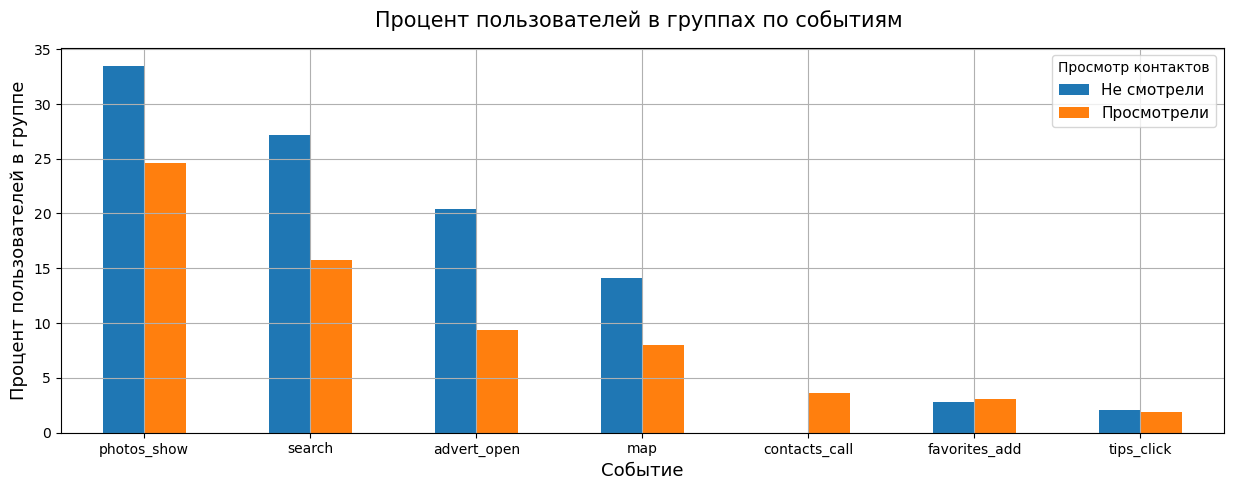

,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search,tips_click
Не смотрели,20.41%,0.0%,0.0%,2.76%,14.09%,33.47%,27.17%,2.1%
Просмотрели,9.32%,3.65%,33.6%,3.07%,8.02%,24.63%,15.78%,1.92%


In [115]:
d_percent_all = d_clean.copy()
total_show = 0
total_no = 0
result_percent = pd.DataFrame()
for column in d_percent_all.columns:
    if column == 'target_event':
        continue
    total_no += int(d_percent_all.query('target_event == "Не смотрели"')[column].sum())
    total_show += int(d_percent_all.query('target_event == "Просмотрели"')[column].sum())
    result_percent.loc['Не смотрели', column] = d_percent_all.query('target_event == "Не смотрели"')[column].sum()
    result_percent.loc['Просмотрели', column] = d_percent_all.query('target_event == "Просмотрели"')[column].sum()

for column in result_percent.columns:
    result_percent.loc['Не смотрели', column] = round(result_percent.loc['Не смотрели', column] / total_no * 100, 2)
    result_percent.loc['Просмотрели', column] = round(result_percent.loc['Просмотрели', column] / total_show * 100, 2)

result_percent.T.drop('contacts_show').sort_values(by='Просмотрели', ascending=False).plot(y=result_percent.index, kind='bar', \
        grid=True, legend=True,
               figsize=(15, 5))
plt.title('Процент пользователей в группах по событиям ', loc ='center', pad = 15, fontsize=15, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Событие', fontsize=13, color='black')
plt.ylabel('Процент пользователей в группе', fontsize=13, color='black')
plt.xticks(rotation=0, ha='center')
plt.legend(fontsize=11, title='Просмотр контактов')
plt.show()
cols = result_percent.columns
result_percent = result_percent.apply([lambda x: str(x) + '%'], axis=0)
result_percent.columns = cols
result_percent

Интересно, что логика выбора действий у обеих групп одинакова, поэтому нельзя сказать, что какие-либо действия свойственны именно аудитории, совершившей целевое действие. Чаще всего просмотревшие контакты смотрят фотографии и пользуются поиском. На втором месте по количеству событий для них расположились просмотр карточек объявлений и карты

#### Вывод: <a id='conclusion5'></a>

Самые популярные сценарии активности не превышают трёх шагов. Диаграмма Сэнкея показала, что самыми популярными первыми шагами являются поиск, просмотр карты и просмотр фотографий. Следующим после этих действий чаще всего является просмотр контактов. Часто встречается и последовательность из трёх шагов: поиск, просмотр фотографий, просмотр контактов. Доли остальных последовательностей не превышают 5%.    

Ворнки по популярным сценариям показали высокую конверсию первых шагов в просмотры контактов: на поиск приходится 13% переходов к просмотру контактов, после просмотра карты 10% переходов к целевому событию, а пользователи, просмотревшие фотографий в 18% случаев после этого перешли к контактам. Также 18% пользователей после поиска просмотрели фотографии, после чего 17% из них просмотрели контакты.    

Рекомендации были показаны 2801 раз, но конверсия в клик по рекомендации оказалась всего 5%. Положительным фактором является то, что 20% кликнувших по рекомендации, просомотрели после этого контакты.  

Разделение пользователей на группы по целевому событию и посчёт процента совершаемых действий внутри групп показал, что логика выбора действий у обеих групп одинакова, поэтому нельзя сказать, что какие-либо действия свойственны именно аудитории, совершившей целевое действие. Чаще всего совершившие целевое действие смотрят фотографии и пользуются поиском. На втором месте по количеству событий для них расположились просмотр карточек объявлений и карты

### Проверка гипотез <a id='hypothesis'></a> 

Для проверки гипотез зададим несколько функций:  
- Функцию для формирования выборок из данных по конверсии.
- Функцию, которая проверит различие дисперсий, после чего проверит гипотезу методом ttest_ind.   
- Функцию проверки гипотезы о равенстве долей.    
При проверке гипотез будем задававть уровень значимости в 5%, чтобы избежать ложноположительных результатов

In [116]:
# Функция для формирования выборок из данных по конверсии
def sample_maker(field, target):
    conversion_raw, conversion, conversion_history = get_conversion(
        profiles, orders, datetime(2019,11,3).date(), 10, dimensions=[field]
    )
    
    sample = []
    target_group = conversion_history.loc[target,:]
    for index in target_group.index:
        for column in target_group.columns:
            
            if column == 'cohort_size':
                continue
            else:
                sample.append(target_group.loc[index, column])
    print('Среднее значение конверсии группы, пришедшей из', target, '=', f'{round(statistics.mean(sample) * 100, 2)}%')
            
    return sample

# Функция проверки гипотез методом scipy.stats.ttest_ind
def hypothesis_checker(field, first_target, second_target, alpha):
    
    first_group = sample_maker(field, first_target) # Распределение параметра первой группы
    second_group = sample_maker(field, second_target) # Распределение параметра второй группы
    
    first_group_var = np.var(first_group, ddof=1)
    second_group_var = np.var(second_group, ddof=1)
    var_difference = abs(1 - first_group_var / second_group_var)

    if var_difference < 0.05:
        equivalent = True
    else:
        equivalent = False

    print('Дисперсия первой выборки:', first_group_var)
    print('Дисперсия второй выборки:', second_group_var)
    print(f'Величины дисперсий различаются на {var_difference:.2%}, '
      f'поэтому параметру "equal_var" задаём значение {equivalent}')

    # Применим метод scipy.stats.ttest_ind, чтобы проверить гипотезу о равенстве средних двух выборок
    results = st.ttest_ind(first_group, second_group, equal_var=equivalent)
    print('p-значение:', (results.pvalue), '\nУровень значимости:', alpha, '\nВывод:')
    # Проверяем p-value
    if (results.pvalue < alpha):
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу')

        
# Функция проверки гипотезы о равенстве долей (z-test)        
def z_test(successes1, successes2, trials1, trials2, alpha=0.05):
    p1 = successes1 / trials1
    p2 = successes2 / trials2

    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value, '\nУровень значимости:', alpha, '\nВывод:')

    if (p_value < alpha):
        print('Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет')

#### Гипотеза о взаимодействии с рекомендациями  <a id='tips'></a>    

Одни пользователи совершают действия tips_show и tips_click , другие — только tips_show. Проверим гипотезу: конверсия в просмотры контактов различается у этих двух групп.    

Сформулируем нулевую и альтернативную гипотезы:    

- **Нулевая гипотеза:** конверсия в просмотры контактов группы пользователей, совершающих действия tips_show и tips_click **равна** конверсии в просмотры контактов группы пользователей, совершающих только действие tips_show.
- **Альтернативная гипотеза:** конверсия в просмотры контактов группы пользователей, совершающих действия tips_show и tips_click **отличается** от конверсии в просмотры контактов группы пользователей, совершающих только действие tips_show.    

Поскольку у нас гипотеза о равенстве долей, для определения статистически значимой разницы между группами, приеменим проверку z-критерием по долям.

In [117]:
# Рассчитываем количество пользователей по группам и количество целевых событий в группе
show_count = data_tips[data_tips['tips'] == 'show']['user_id'].count()
show_click_count = data_tips[data_tips['tips'] == 'show_click']['user_id'].count()
show_target = data_tips[(data_tips['tips'] == 'show') & (data_tips['target'] == 1)]['user_id'].count()
show_click_target = data_tips[(data_tips['tips'] == 'show_click') & (data_tips['target'] == 1)]['user_id'].count()

# Вызываем функцию проверки гипотезы о равенстве долей (z-test)  
z_test(show_target, show_click_target, show_count, show_click_count, alpha=0.05)

p-значение:  1.6040586636734133e-08 
Уровень значимости: 0.05 
Вывод:
Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия


Полученное при проверке гипотезы значение P-value значительно меньше уровня значимости в 5%, по результатам проверки **нулевая гипотеза отвергается** - конверсия в просмотры контактов группы пользователей, совершающих действия tips_show и tips_click статистически значимо различается с конверсией в просмотры контактов группы пользователей, совершающих только действие tips_show

#### Гипотеза об источниках трафика <a id='source'></a>    

Одни пользователи пришли из Yandex, другие из Google. Проверим гипотезу: конверсия в просмотры контактов различается у этих двух групп.

Сформулируем нулевую и альтернативную гипотезы:    

- **Нулевая гипотеза:** среднее значение конверсии пользователей, пришедших из Yandex **равно** среднему значению конверсии пользователей, пришедших из Google.
- **Альтернативная гипотеза:** среднее значение конверсии пользователей, пришедших из Yandex **отличается** от среднего значения конверсии пользователей, пришедших из Google.    

Поскольку у нас две независимые выборки и гипотеза о равенстве средних двух генеральных совокупностей, для проверки применим метод **scipy.stats.ttest_ind**

In [118]:
hypothesis_checker(field='source', # Выбираем поле
                   first_target='yandex', # Задаём первую выборку
                   second_target='google', # Задаём вторую выборку
                   alpha=0.05) # Задаём уровень значимости 5%

Среднее значение конверсии группы, пришедшей из yandex = 22.25%
Среднее значение конверсии группы, пришедшей из google = 21.96%
Дисперсия первой выборки: 0.0023049474232526702
Дисперсия второй выборки: 0.0052138486539387505
Величины дисперсий различаются на 55.79%, поэтому параметру "equal_var" задаём значение False
p-значение: 0.6435905543357765 
Уровень значимости: 0.05 
Вывод:
Не получилось отвергнуть нулевую гипотезу


Разница между дисперсиями выборок составляет 55.79%, считать дисперсии выборок равными нельзя, поэтому зададим аргумент equal_var=False.
P-value составляет 64.3%, что значительно больше 5%, по результатам проверки **не получилось отвергнуть нулевую гипотезу** - среднее значение конверсии пользователей, пришедших из Yandex статистически значимо не отличается от среднего значения конверсии пользователей, пришедших из Google

#### Вывод: <a id='conclusion6'></a>

Чтобы определить предпочтения пользователей совершивших целевое действие сформулировали две гипотезы:

- Первая гипотеза: одни пользователи совершают действия tips_show и tips_click , другие — только tips_show. Конверсия в просмотры контактов различается у этих двух групп.    

    - Нулевая гипотеза: конверсия в просмотры контактов группы пользователей, совершающих действия tips_show и tips_click равна конверсии в просмотры контактов группы пользователей, совершающих только действие tips_show.
    - Альтернативная гипотеза: конверсия в просмотры контактов группы пользователей, совершающих действия tips_show и tips_click отличается от конверсии в просмотры контактов группы пользователей, совершающих только действие tips_show.    
    
Поскольку это гипотеза о равенстве долей, для определения статистически значимой разницы между группами, приеменили проверку z-критерием по долям. Уровень значимости задали в 5% чтобы избежать ложноположительных результатов. Полученное при проверке гипотезы значение P-value оказалось значительно меньше уровня значимости в 5% и по результатам проверки нулевая гипотеза была отвергнута - конверсия в просмотры контактов группы пользователей, совершающих действия tips_show и tips_click статистически значимо различается с конверсией в просмотры контактов группы пользователей, совершающих только действие tips_show.

- Вторая гипотеза: одни пользователи пришли из Yandex, другие из Google. Конверсия в просмотры контактов различается у этих двух групп.    

    - Нулевая гипотеза: среднее значение конверсии пользователей, пришедших из Yandex равно среднему значению конверсии пользователей, пришедших из Google.
    - Альтернативная гипотеза: среднее значение конверсии пользователей, пришедших из Yandex отличается от среднего значения конверсии пользователей, пришедших из Google.

Поскольку выдвинутая гипотеза относятся к классу гипотез о равенстве средних двух выборок, для их проверки применили метод scipy.stats.ttest_ind. Уровень значимости задали в 5% чтобы избежать ложноположительных результатов. Проверка гипотезы показала, что значение P-value составляет 64.3%, что значительно больше 5%, в следствие чего не получилось отвергнуть нулевую гипотезу - среднее значение конверсии пользователей, пришедших из Yandex статистически значимо не отличается от среднего значения конверсии пользователей, пришедших из Google

### Результаты исследования <a id='result'></a>

Исследование проводилось на основе таблицы mobile_sources.csv, содержаще 4293 записи и таблицы **mobile_dataset.csv** содержащей 74197 записей о действиях пользователей. Загрузка таблиц прошла без ошибок. Были обнаружены несоответствия формата данных в одном из столбцов и несоответствия названий столбцов "змеиному" формату. Полученная выборка являлась достаточной для проведения исследования.    

**Предобработка**

В ходе предобработки названия столбцов были приведены к "змеиному" регистру. Значения в столбце `event_time` приведены к формату datetime. Полные дубликаты отсутствовали. При проверке неявных дубликатов, в столбце `event_name` были обнаружены уникальные значения, характерные для событий одного типа, но с разными названиями: 'show_contacts' и 'contacts_show';  'search_1', 'search_2', 'search_3', 'search_4', 'search_5', 'search_6', 'search_7'. Для оценки действий пользователей по типу активности, данные значения были объединены в единые смысловые блоки - 'contacts_show' и 'search'. Пропуски в обеих таблицах отсутствовали. Данные были подготовлены для проведения анализа.

**Исследовательский анализ данных**

В таблица с событиями содержала данные о 74197 действиях, совершенных 4293 уникальными пользователями с 2019-10-07 по 2019-11-03. Наиболее частым событием в данных оказалось 'tips_show', оно встречалось в 40 раз чаще других событий, но, поскольку оно не зависит от действий пользователя, а нам важно было учитывать именно пользовательские алгоритмы, события 'tips_show' были удалены и далее рассмотрены отдельно в ходе исследования.    

По очищеным данным, больше всего событий было связано с просмотром фотографий - 10012. На втором месте в рейтинге событий - действия, связанные с поиском - 6784 события. Замыкает тройку лидеров - просмотр карточек объявления - 6164 просмотра. Хорошим знаком является то, что целевое действие - просмотр контактов, находится на четвёртом месте по количеству событий в данных - 4529 просмотров.    

В среднем пользователи совершают не больше двух одинаковых действий. Самое частое действие - просмотр фотографий - в среденем 1.97 просмотров на пользователя, второе - поиск (в среденем 1.51 запросов на пользователя), замыкает тройку лидеров - просмотр карточек (в среденем 1.08 просмотров на пользователя). Целевое действие совершается уже реже - в среднем 0.69 просмотров контактаов на пользователя.    

В разрезе целевого события, при одинаковых количествах действий пользователей, большая их часть не совершает целевое действие, что связано с разной величиной выборок по целевому событию, чтобы нивелировать эту разницу, были посчитаны относительные значения величин, которые разделили события на две группы: пользователи, не совершившие целевое действие чаще используют поиск, просматривают карточки объявлений и карту; пользователи, совершившие целевое действие чаще смотрят фотографии, добавляют в избранное и кликают по рекомендациям.    

Динамика совершения целевых событий по времени довольно стабильна и не отходит далеко от среднего значения - 161.75 событий в день. Прослеживается влияние недельных циклов активности. На начальном этапе наблюдения значения ниже средних, что является следствием того, что в исследовании участвуют только новые пользователи и в первую неделю мы видим только их активность, в последующие недели к ним прибавляется активность новых пользователей и количество просмотров контактов вырастает.

Самой популярной платформой для установки приложения является Яндекс - 1934 установки, Google отстал почти в два раза - 1129 установок. Из прочих источников накопилось 1230 установок, что что вывело прочие источники на второе место в рейтинге платформ

**Продуктовые метрики**

Динамика количества аутентичных пользователей по дням довольно стабильна и близка к среднему значению за период наблюдений - 279.18 уникальных пользователей. Прослеживается влияние недельных циклов активности и пониженное значение на первой неделе, из-за использования в исследовании только данных новых юзеров, без учёта активности ранее зарегистриованных пользователей

В целом пользователи показывают хороший уровень конверсии 22.2% на десятый день. Каждый пятый пользователь совершает целевое действие. За десять дней жизни когорты, показатель конверсии вырос на 5 процентных пунктов.

Расчёт показал, что конверсия лучше у пользователей, посмотревших рекомендации и кликнувших на них, чем у пользователей, которые только посмотрели рекомендации. Разница в конверсии на десятый день составила более 10 процентных пунктов. Также конверсия посмотревших и кликнувших на рекомендации выше средней конверсии по всем пользователям на 6 процентных пунктов.

Конверсия по источникам установки приложения у Yandex и Google показала схожие значения: 23.79% и 23.86% соответственно. Это выше значения конверсии по всем пользователям примерно на полтора процентных пункта. Конверсия пользователей, пришедших из других источников сильно отстаёт и не превышает 18%.

Медианное значение длительности сессии для пользователей составляет 611 секунд, но в данных присутствует значительное число сессий с повышенной длительностью, которые утягивают среднее вверх до длительности 1137 секунд. Для пользователей, не совершивших целевое действие, медианное и среднее значение длительности сессии чуть меньше общего и составляет 564 и 1033 секунд соответственно, большая часть значений не превышает полутора тысяч секунд, а сессии более 3000 секунд можно считать аномально большими. Для пользователей, которые совершили целевое действие, напротив характерна медианная и средняя длительность сесси выше общих: медианное значение - 870 секунд, среднее - 1569 секунд, разброс значений также смещён в большую сторону: 75% сессий имеют длительность до 2196 секунд, а аномальные большими значениями длительности можно считать сессии, продолжающиеся более 5000 секунд


**Сценарии активности пользователей**

Самые популярные сценарии активности не превышают трёх шагов. Диаграмма Сэнкея показала, что самыми популярными первыми шагами являются поиск, просмотр карты и просмотр фотографий. Следующим после этих действий чаще всего является просмотр контактов. Часто встречается и последовательность из трёх шагов: поиск, просмотр фотографий, просмотр контактов. Доли остальных последовательностей не превышают 5%.

Ворнки по популярным сценариям показали высокую конверсию первых шагов в просмотры контактов: на поиск приходится 13% переходов к просмотру контактов, после просмотра карты 10% переходов к целевому событию, а пользователи, просмотревшие фотографий в 18% случаев после этого перешли к контактам. Также 18% пользователей после поиска просмотрели фотографии, после чего 17% из них просмотрели контакты.    

Рекомендации были показаны 2801 раз, но конверсия в клик по рекомендации оказалась всего 5%. Положительным фактором является то, что 20% кликнувших по рекомендации, просомотрели после этого контакты.     

Разделение пользователей на группы по целевому событию и посчёт процента совершаемых действий внутри групп показал, что логика выбора действий у обеих групп одинакова, поэтому нельзя сказать, что какие-либо действия свойственны именно аудитории, совершившей целевое действие. Чаще всего совершившие целевое действие смотрят фотографии и пользуются поиском. На втором месте по количеству событий для них расположились просмотр карточек объявлений и карты

**Проверка гипотез**

Чтобы определить предпочтения пользователей, совершивших целевое действие, были сформулированы следующие гипотезы:   

- Первая гипотеза: одни пользователи совершают действия tips_show и tips_click , другие — только tips_show. Конверсия в просмотры контактов различается у этих двух групп.    

    - Нулевая гипотеза: конверсия в просмотры контактов группы пользователей, совершающих действия tips_show и tips_click равна конверсии в просмотры контактов группы пользователей, совершающих только действие tips_show.
    - Альтернативная гипотеза: конверсия в просмотры контактов группы пользователей, совершающих действия tips_show и tips_click отличается от конверсии в просмотры контактов группы пользователей, совершающих только действие tips_show.    
    
По результатам проверки нулевая гипотеза была отвергнута - конверсия в просмотры контактов группы пользователей, совершающих действия tips_show и tips_click статистически значимо различается с конверсией в просмотры контактов группы пользователей, совершающих только действие tips_show.

- Вторая гипотеза - одни пользователи пришли из Yandex, другие из Google. Конверсия в просмотры контактов различается у этих двух групп.    

    - Нулевая гипотеза: среднее значение конверсии пользователей, пришедших из Yandex равно среднему значению конверсии пользователей, пришедших из Google.
    - Альтернативная гипотеза: среднее значение конверсии пользователей, пришедших из Yandex отличается от среднего значения конверсии пользователей, пришедших из Google.

По результатам проверки не получилось отвергнуть нулевую гипотезу - среднее значение конверсии пользователей, пришедших из Yandex статистически значимо не отличается от среднего значения конверсии пользователей, пришедших из Google.


**Вывод:**    
   
- Ежедневно на платформу заходит 279 уникальных пользователей, 22% из них течение десяти дней просматривают контакты. Среднее время сессии пользователей, просмотревших контакты составляет 1569 секунд. Чаще всего, совершившие целевое действие, начинают взаимодействие с приложением через поиск, просмотр карты или просмотр фотографий, поэтому важно обеспечить таким пользователям удобный доступ к данным функциям на этапе входа в приложение. Конверсия переходов от этих функций к просмотру контактов находится на уровне 13% - 18%, это хорошие значения, но вероятно, конверсия ещё имеет потенциал роста при оптимизации функций поиска, отображения карты и показа фотографий.    
- Как показала проверка гипотез, ещё одной особенностью пользователей, совершивших целевое действие, является то, что они чаще кликают по рекомендациям, но конверсия от показа рекомендаий к клику по ним составляет всего 5%. Исходя из этого, можно сделать вывод, что более точная настройка рекомендаций под интересы пользователя может улучшить количество переходов от показа рекомендаций к клику по ним и поднять общую конверсию. Учитывая, что за 10 дней жизни когорты рост конверсии составляет 5 процентных пунктов, это показатель можно повысить, накапливая данные запросов пользователя за указаный период, и на их основе выдавая улучшенные рекомендации.    
- Принимая во внимание, что проверка гипотезы показала отсутствие статистических различий средних значений конверсии пользователей, пришедших с платформ Yandex и Google, то выбор целевой платформы для привлечения трафика можно проводить по параметрам, не связанным с активностью пользователей.